<h1><center> Efficacy Comparison of Descriptor modeling and Graph modeling for Ligand Based Virtual Screening </center>
    
## Hugo Hakem Meng BioE 23-24'

#### Acknowledgement
This work stands as the final project for the Chem / BioE242 class taught in Spring2024 by Professor. Teresa Head-Gordon, and GSI. Yingze (Eric) Wang.

# 0) Some background and motivation
**Virtual Screening (VS)** is a method commonly used in drug discovery compaign within big pharmaceutical compagnies. The key idea lies in the fact that from a large virtual databases of available compounds, the goal is to extract a small focused subsets with an enriched fraction of active compounds in regard of a specific target. This target is often a protein associated to a disease. The motivation behind VS is to speed up biological testing. [1]

**Ligand Based Virtual Screening (LBVS)** is based on the assumption that active compound must be similar with each other, and similar to known active compound or Ligand, which bound to the desired target. The similarity can either be structural, or in term of chemical properties. [2][3]

This project aims to answer wether or not it is more efficient to model compounds using chemical descriptors or a graph representation in regards of bioactivity classification to a target. 

The dataset chosen for this purpose is the MUV Dataset. It is downloadable on the __[MoleculeNet Database](https://moleculenet.org/datasets-1)__[4]. This Dataset has been chosen because the MUV Dataset is a the first benchmarking Dataset ever created for LBVS. It stands for Maximum Unbiased Validation Dataset as it address two important bias which can lead to overestimation on the performance of VS model. [2][3] 

1. Adress Artificial Enrichment Bias:
   + Unactive compounds too different from Active compounds.
2. Adress Analogue Bias:
   + Active compounds too similar with each others.

The similarity within compounds has been computed using simple descriptors [2]: 
number of Atoms, number of Heavy Atoms, number of each of these atoms: [B, Br, C, Cl, F, I, N, O, P, S], number of Hydrogen Bond Acceptor, Hydrogen Bond Donor, LogP value, the number of ChiralCenter, and number of Rings. This is importatnt to kno in the context of Descriptor modeling as those descriptor may therefore not be very efficient for classification purposes as they have been used so that compounds (active or not) of this data set is well scattered into this chemical space. 

This Dataset is partitionned as follow.
1. [Descriptor Modeling](#DescModeling)
   + [Dataset](#DescDataset)
   + [Preprocessing](#DescPreprocessing)
   + [Splitting Method](#DescSplit)
   + [Model](#DescModel)
   + [Result](#DescResult)
2. [Graph Modeling](#GraphModeling)
   + [Dataset](#GraphDataset)
   + [Preprocessing](#GraphPreprocessing)
   + [Splitting Method](#GraphSplit)
   + [Model](#GraphModel)
   + [Trainer](#GraphTrainer)
   + [Result](#GraphResult)
3. [Conclusion](#Conclusion)
   + [Comparison of the 2 modeling](#ConcComparison)
   + [Comparison with the litterature](#ConcCompLitt)
   + [General conclusion](#ConcGeneral)

This Notebook has been designed so the part I entitled "Descriptor Modeling" and the part II entitled "Graph Modeling" can be runned totally independently. 


To run the present Notebook, here is a list of command to run sequentially and which will install the package required. 

```conda install ipykernel conda-forge -y```
```conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia```
```conda install pyg -c pyg```
```conda install pandas matplotlib seaborn seaborn rdkit -c conda-forge -y```
```conda install -c conda-forge py-xgboost```
```pip install imxgboost```
```pip install networkx```

Here is a list of references where later part will refer to. 
#### References
[1] Gimeno, Aleix, et al. « The Light and Dark Sides of Virtual Screening: What Is There to Know? » International Journal of Molecular Sciences, vol. 20, no 6, march 2019, p. 1375. PubMed Central, https://doi.org/10.3390/ijms20061375].
<br>
[2] Rohrer, Sebastian G., et Knut Baumann. « Maximum Unbiased Validation (MUV) Data Sets for Virtual Screening Based on PubChem Bioactivity Data ». Journal of Chemical Information and Modeling, vol. 49, no 2, february 2009, p. 169-84. DOI.org (Crossref), https://doi.org/10.1021/ci8002649.
<br>
[3] Xia, Jie, et al. « Benchmarking methods and data sets for ligand enrichment assessment in virtual screening ». Methods, vol. 71, january 2015, p. 146-57. ScienceDirect, https://doi.org/10.1016/j.ymeth.2014.11.015
<br>
[4] Datasets. https://moleculenet.org/datasets-1. Consulted 4 april 2024.
<br>
[5] « How to explain the ROC AUC score and ROC curve? » Consulté le: 25 avril 2024. [web]. Available: https://www.evidentlyai.com/classification-metrics/explain-roc-curve
<br>
[6] « 6.1: Molecular Descriptors ». Chemistry LibreTexts, 26 october 2019, https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics/06%3A_Molecular_Similarity/6.01%3A_Molecular_Descriptors.
<br>
[7] J. Li, D. Cai, et X. He, « Learning Graph-Level Representation for Drug Discovery ». arXiv, 15 septembre 2017. Consulted: 25 april 2024. [Web] Available: http://arxiv.org/abs/1709.03741
<br>
[8] C. Wang, C. Deng, et S. Wang, « Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost». 2019.
<br>
[9] « Introduction to Scaffold Splitting - Oloren AI ». Consulted: 25 april 2024. [Web]. Available: https://www.oloren.ai/blog/scaff-split
<br>
[10] W. Hu et al., « Open Graph Benchmark: Datasets for Machine Learning on Graphs », arXiv preprint arXiv:2005.00687, 2020.
<br>
[11] P. Li et al., « TrimNet: learning molecular representation from triplet messages for biomedicine », Briefings in Bioinformatics, nov. 2020, doi: 10.1093/bib/bbaa266.
[12] « Supports Fidle - En ligne ». Cloud UGA, https://cloud.univ-grenoble-alpes.fr/s/wxCztjYBbQ6zwd6. Consulted on April, 27th 2024.

# 1) Descriptor Modeling <a id="DescModeling"></a>

## a) Dataset <a id="DescDataset"></a>

### i) Dataset loading

Let's start with loading the MUV dataset from a previously downloaded CSV file found in [4]. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import xgboost
from xgboost import XGBClassifier
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors as Desc
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  

In [11]:
df = pd.read_csv('./Dataset_MUV/muv.csv', sep=',', index_col='mol_id')
df = df[['smiles']+df.columns.to_list()[:-1]]
print(f"Numb of molecules: {df.shape[0]}")
print(f"Numb of target: {df.shape[1] - 1}")
df.head()

Numb of molecules: 93087
Numb of target: 17


smiles  MUV-466  \
mol_id                                                                   
CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C      NaN   
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1      0.0   
CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...      NaN   
CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...      NaN   
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O      0.0   

            MUV-548  MUV-600  MUV-644  MUV-652  MUV-689  MUV-692  MUV-712  \
mol_id                                                                      
CID2999678      NaN      NaN      NaN      NaN      NaN      NaN      0.0   
CID2999679      0.0      NaN      NaN      0.0      0.0      0.0      NaN   
CID2999672      NaN      0.0      NaN      NaN      NaN      NaN      NaN   
CID5390002      0.0      0.0      NaN      NaN      0.0      NaN      NaN   
CID2999670      NaN      NaN      NaN      0.0      NaN      0.0      0.0   

            MUV-713  MUV-733  MUV-737  MUV-810  MUV-832  MUV-846  MUV-852  \
mol_id                                                                      
CID2999678      NaN      NaN      NaN      0.0      NaN      NaN      NaN   
CID2999679      NaN      NaN      0.0      NaN      0.0      NaN      NaN   
CID2999672      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
CID5390002      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
CID2999670      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            MUV-858  MUV-859  
mol_id                        
CID2999678      NaN      NaN  
CID2999679      0.0      0.0  
CID2999672      NaN      0.0  
CID5390002      0.0      NaN  
CID2999670      NaN      NaN

The MUV Dataset is composed of 93087 compounds with 17 Target which stands for 17 challenging classification tasks.   

In [12]:
df_composition = pd.concat([(df.iloc[:,1:] == 1).sum(axis=0), 
                            (df.iloc[:,1:] == 0).sum(axis=0), 
                            100 * (df.iloc[:,1:] == 1).sum(axis=0) / (~df.iloc[:,1:].isna()).sum(axis=0)], 
          axis=1)
df_composition = df_composition.rename(columns={0:"PositiveCount", 1:"FalseCount", 2:"PositiveRate (%)"})
df_composition

PositiveCount  FalseCount  PositiveRate (%)
MUV-466             27       14814          0.181928
MUV-548             29       14705          0.196824
MUV-600             30       14698          0.203694
MUV-644             30       14593          0.205156
MUV-652             29       14873          0.194605
MUV-689             29       14572          0.198617
MUV-692             30       14614          0.204862
MUV-712             28       14383          0.194296
MUV-713             29       14807          0.195470
MUV-733             28       14654          0.190710
MUV-737             29       14662          0.197400
MUV-810             29       14615          0.198033
MUV-832             30       14637          0.204541
MUV-846             30       14681          0.203929
MUV-852             29       14622          0.197939
MUV-858             29       14745          0.196291
MUV-859             24       14722          0.162756

These classification tasks are indeed challenging due to the fact that the dataset is very unbalanced. Just 0.2% of active compound in average which does not give a lot of example to learn on to perform a classification. In addition, since the artificial enrichment bias and the analogue bias has been addressed, it means that positive example has been specifically kept so they are somewhat alike to unactive compounds. These consideration will lead to special features in the model part. 

In [13]:
print(f"Number of molecule that are positive without considering targets:\n{((df.iloc[:,1:] == 1).sum(axis=1) >=1).sum()}")
print(f"Number of molecule that are positive more than 1 times:\n{((df.iloc[:,1:] == 1).sum(axis=1) >1).sum()}")
print(f"Number of molecule that are positive more than 1 times and may be negative for some target:\n{((df.loc[((df.iloc[:,1:] == 1).sum(axis=1) >=2)].iloc[:,1:] == 0).sum(axis=1) > 0).sum()}")
print(f"Number of molecule that are positive more than 2 times:\n{((df.iloc[:,1:] == 1).sum(axis=1) >2).sum()}")
print(f"Number of molecule that are positive more than 3 times:\n{((df.iloc[:,1:] == 1).sum(axis=1) >3).sum()}")

Number of molecule that are positive without considering targets:
471
Number of molecule that are positive more than 1 times:
16
Number of molecule that are positive more than 1 times and may be negative for some target:
15
Number of molecule that are positive more than 2 times:
2
Number of molecule that are positive more than 3 times:
0


The dataset is filled with NaN values and replace them is impossible. Indeed, creating a third classification category such as: number 2 meaning not tested, does not make sense as the classifiers should not have to learn if a moleule has been tested or not. So the NaN values should be replaced by a 0 or a 1 but as the different print show it, some moleule might be active more than once. So how deciding about NaN values without adding some bias. The most conservative way is therefore to split the Dataset into 17 sub data sets. 

### ii) Molecule Visualisation 
Let's have a look on what does active or unactive molecues looks like.  

In [14]:
def display_row(pictures, activity, picture_height=5, picture_width=5):
    """ 
        Display the pictures in line
        Parameters
        ----------
        pictures(list(bytes)): a list of bytes pictures
        activity(string): string to be inserted into the title. Either 'active' or 'unactive' 
        picture_height(float): the height of one picture
        picture_width(float): the width of one picture
        
        Output
        -------
        Row of pictures with the length of pictures.
    """
    num_pic = len(pictures)
    fig = plt.figure(figsize=(num_pic*picture_width, picture_height))
    for i in range(num_pic):
        fig.add_subplot(1, num_pic, i+1)
        plt.imshow(pictures[i])
        plt.axis('off')
    plt.suptitle(f"Example of {num_pic} {activity} molecule(s)", fontsize=20)

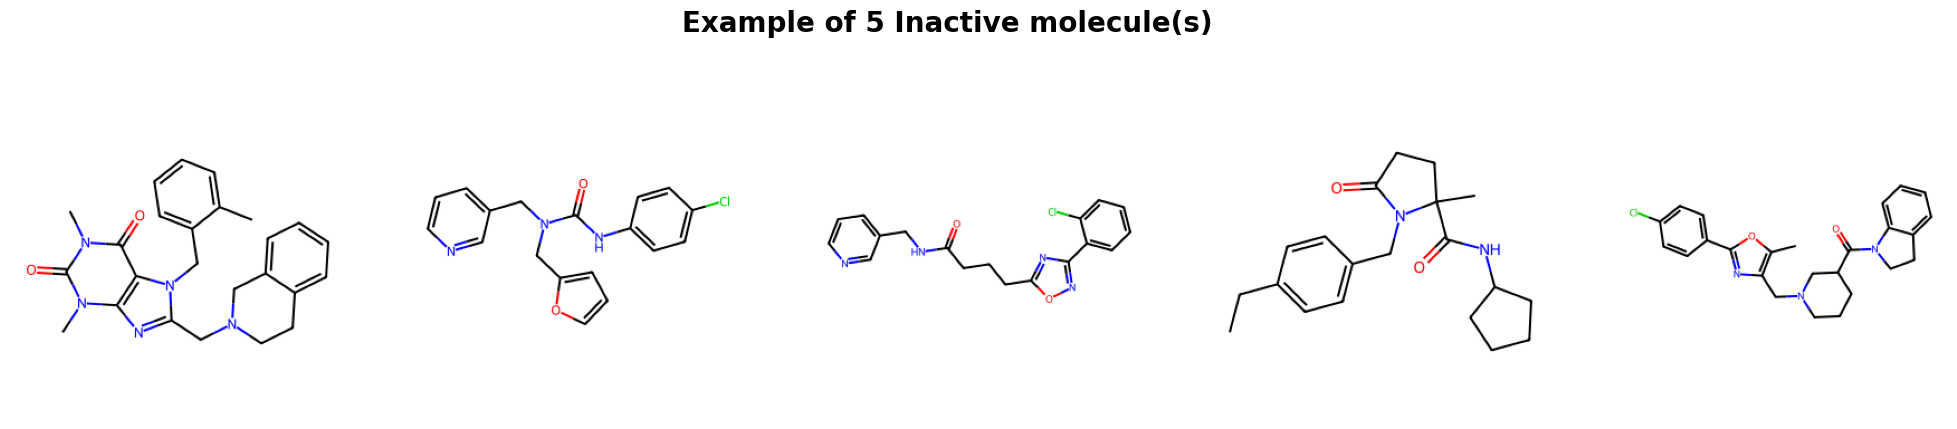

In [15]:
num_gen = 5
inactive_molecules = df["smiles"][df["MUV-466"]==0].values
examples_inactive = [Chem.Draw.MolToImage(Chem.MolFromSmiles(x), size=(300,300)) for x in 
                     inactive_molecules[np.random.randint(0,len(inactive_molecules), num_gen)]]
display_row(examples_inactive, activity="Inactive")
#plt.savefig("./Image/ExInactiveMol")

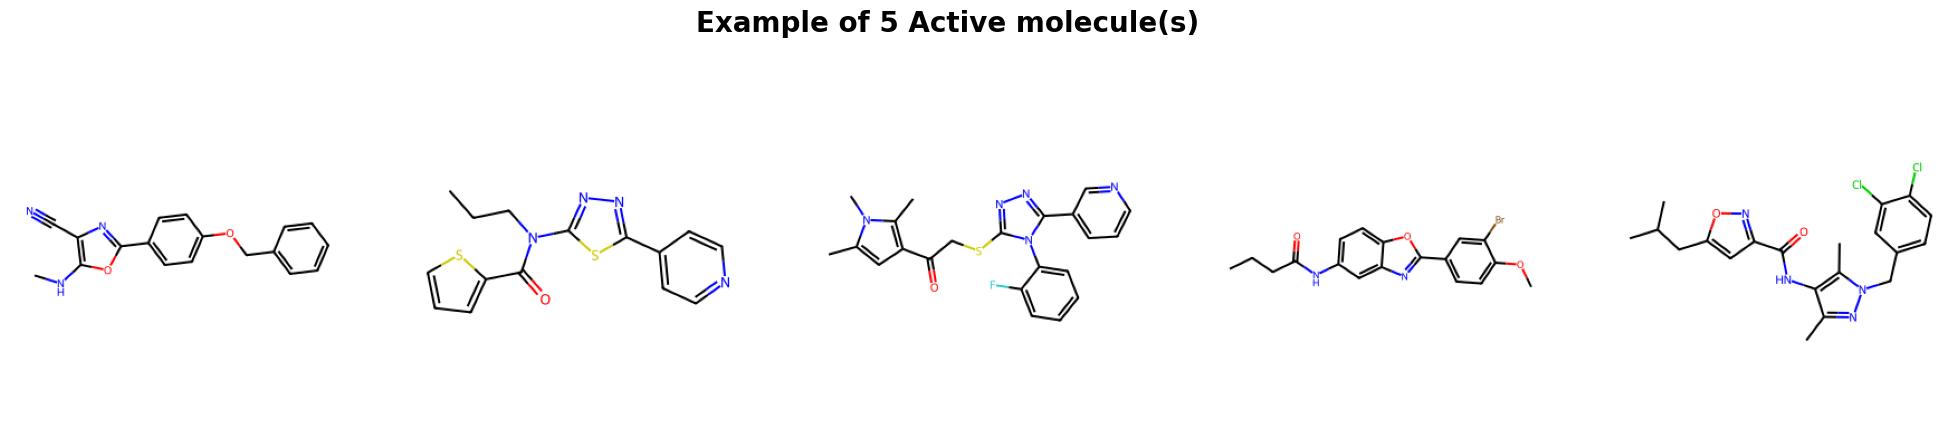

In [16]:
active_molecules = df["smiles"][df["MUV-466"]==1].values
examples_active = [Chem.Draw.MolToImage(Chem.MolFromSmiles(x), size=(300,300)) for x in 
                     active_molecules[np.random.randint(0,len(active_molecules), num_gen)]]
display_row(examples_active, activity="Active")
#plt.savefig("./Image/ExActiveMol")

## b) Preprocessing <a id="DescPreprocessing"></a>

### i) Descriptor dataframe creation
Let's create function which take into account the MUV dataframe and which output the new dataframe of descriptors for the smiles into the originary dataset. 
+ SimpleDescriptor, based on the MUV paper [2]. 
+ MACCSDescriptor. MACCS keys is the second set of descriptor chosen and is suggested to be used in the MUV paper[2]. MAACS keys are explained in [6].
+ ComplexDescriptor is the last set chosen. It is generated using rdkit with the function CalcMolDescriptors.
+ MergeDescriptor is just a combination of all those 3 precedent set. 

In [18]:
def Table_SimpleDescriptors(df):
    '''
    Create, Save and Load the MUV Simple Descriptor Dataset.

    Parameters
    ---------
    df: pandas.DataFrame 
        The whole MUV dataframe
        
    Output
    ---------
    Descriptor_df: pd.DataFrame 
        MUV Simple Descriptor dataframe
    '''

    if os.path.exists('./Dataset_MUV/muv_simple_descriptor.csv'):
        if pd.read_csv('./Dataset_MUV/muv_simple_descriptor.csv', sep=',', index_col='mol_id').empty == False:
            Descriptor_df = pd.read_csv('./Dataset_MUV/muv_simple_descriptor.csv', sep=',', index_col='mol_id')
            return Descriptor_df
    else:
        Descriptor_dict = {"mol_id":[], "smiles":[],
            "NumAtoms":[],
            "NumHeavyAtoms":[],
            "B":[], 
            "Br":[],
            "C":[],
            "Cl":[], 
            "F":[], 
            "I":[],  
            "N":[], 
            "O":[],  
            "P":[],  
            "S":[], 
            "HBA":[],
            "HBD":[],
            "LogP":[],
            "ChiralCenter":[],
            "NumRings":[]}
        Num_Atomic = {"B":5, 
            "Br":35,
            "C":6,
            "Cl":17, 
            "F":9, 
            "I":5,  
            "N":7, 
            "O":8,  
            "P":15,  
            "S":16}
        
        for id, m in tqdm(list(df["smiles"].items()), leave=True):
            if Chem.MolFromSmiles(m) == None:
                continue
            else:
                Descriptor_dict["mol_id"].append(id)
                Descriptor_dict["smiles"].append(m)
                mol = Chem.MolFromSmiles(m)
                Descriptor_dict["NumAtoms"].append(Desc.CalcNumAtoms(mol))
                Descriptor_dict["NumHeavyAtoms"].append(Desc.CalcNumHeavyAtoms(mol))
                Descriptor_dict["NumRings"].append(Desc.CalcNumRings(mol))
                Descriptor_dict["HBA"].append(Desc.CalcNumHBA(mol))
                Descriptor_dict["HBD"].append(Desc.CalcNumHBD(mol))
                Descriptor_dict["ChiralCenter"].append(len(Chem.FindMolChiralCenters(mol)))
                Descriptor_dict["LogP"].append(Crippen.MolLogP(mol))
                for atom, numb in list(Num_Atomic.items()):
                    Descriptor_dict[atom].append(len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#"+str(numb)+"]"))))
        Descriptor_df = pd.DataFrame.from_dict(Descriptor_dict, orient="columns")
        Descriptor_df = Descriptor_df.set_index("mol_id")
        #Now that the descriptor dataframe is created, let's remove dataset with nul variance
        Descriptor_df = Descriptor_df.loc[:][["smiles"] + list(Descriptor_df.iloc[:,1:].keys()[(Descriptor_df.iloc[:,1:].var(axis=0) != 0)])]
        Descriptor_df.to_csv('./Dataset_MUV/muv_simple_descriptor.csv', index_label="mol_id")
        return Descriptor_df

def Table_MACCSDescriptor(df):
    '''
    Create, Save and Load the MUV MACCS Descriptor Dataset.

    Parameters
    ---------
    df: pandas.DataFrame 
        The whole MUV dataframe
        
    Output
    ---------
    MACCS_df: pd.DataFrame 
        MUV MACCS Descriptor dataframe
    '''
    if os.path.exists('./Dataset_MUV/muv_MACCS_descriptor.csv'):
        if pd.read_csv('./Dataset_MUV/muv_MACCS_descriptor.csv', sep=',', index_col='mol_id').empty == False:
            Descriptor_df = pd.read_csv('./Dataset_MUV/muv_MACCS_descriptor.csv', sep=',', index_col='mol_id')
            return Descriptor_df
    else:
        MACCS_list = []
        for id, m in tqdm(list(df["smiles"].items())):
            if Chem.MolFromSmiles(m) == None:
                continue
            else:
                MACCS_list.append([id, m])
                MACCS_list[-1] = MACCS_list[-1] + list(Desc.GetMACCSKeysFingerprint(Chem.MolFromSmiles(m)))
        MACCS_df = pd.DataFrame(MACCS_list, columns=["mol_id", "smiles"]+["MACCS_"+str(i) for i in range(len(MACCS_list[0][2:]))])
        MACCS_df = MACCS_df.set_index("mol_id")
        MACCS_df = MACCS_df.loc[:][["smiles"] + list(MACCS_df.iloc[:,1:].keys()[(MACCS_df.iloc[:,1:].var(axis=0) != 0)])]
        MACCS_df.to_csv('./Dataset_MUV/muv_MACCS_descriptor.csv', index_label="mol_id")
        return MACCS_df


def Table_ComplexDescriptor(df):
    '''
    Create, Save and Load the MUV Complex Descriptor Dataset.

    Parameters
    ---------
    df: pandas.DataFrame 
        The whole MUV dataframe
        
    Output
    ---------
    Descriptor_df: pd.DataFrame 
        MUV Descriptor dataframe generated with Descriptors.CalcMolDescriptors
    '''
    if os.path.exists('./Dataset_MUV/muv_complex_descriptor.csv'):
        if pd.read_csv('./Dataset_MUV/muv_complex_descriptor.csv', sep=',', index_col='mol_id').empty == False:
            Descriptor_df = pd.read_csv('./Dataset_MUV/muv_complex_descriptor.csv', sep=',', index_col='mol_id')
            return Descriptor_df
    else:
        Descriptor_dict = {"mol_id":[], "smiles": []}
        Descriptor_dict.update({k: [] for k in list((Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(df.iloc[0,0]))).keys())})
        for id, m in tqdm(list(df["smiles"].items())):
            if Chem.MolFromSmiles(m) == None:
                continue
            else:
                Descriptor_dict["mol_id"].append(id)
                Descriptor_dict["smiles"].append(m)
                for k, v in list(Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(m)).items()):
                    Descriptor_dict[k].append(v)
        Descriptor_df = pd.DataFrame.from_dict(Descriptor_dict, orient="columns")
        Descriptor_df = Descriptor_df.set_index("mol_id")
        #Now that the descriptor dataframe is created, let's remove dataset with nul variance
        Descriptor_df = Descriptor_df.loc[:][["smiles"] + list(Descriptor_df.iloc[:,1:].keys()[(Descriptor_df.iloc[:,1:].var(axis=0) != 0)])]
        Descriptor_df.to_csv('./Dataset_MUV/muv_complex_descriptor.csv', index_label="mol_id")
        return Descriptor_df

Let's create a function for visualisation purposes. Here PCA plot is used to visualise how much active and unactive compounds are scattered in the chemical space created by the descriptors.

In [19]:
def PCA_plot(Descriptor, df, numb, name, save=False): 
    '''
    Create a PCA plot for an input number of target considering the input Descriptor and save it if desired.

    Parameters
    ----------
    Descriptor(DataFrame): Dataframe of the desired descriptor. It can either be SimpleDescriptor, MACCSDescriptor, ComplexDescriptor,
        MergeDescriptor.
    df(DataFrame): must be the MUV dataframe. 
    numb(int): the desired number of target to plot. 
    save(bool): if the plot should be saved. (not, to run this notebook, it might be needed to change the directory. 

    Output
    -------
    PCA plot. No return.  
    
    '''
    Target_list = list(df.iloc[:,1:].columns)
    fig, axes = plt.subplots(int(np.ceil(numb/4)), 4, figsize=(15,4*int(np.ceil(numb/4))))
    axes = axes.flatten()
    variance = []
    for i, target in enumerate(Target_list[:numb]):
        
        Processed_feature = (Descriptor.iloc[:,1:] - Descriptor.iloc[:,1:].mean(axis=0)) / Descriptor.iloc[:,1:].std(axis=0)
        pca = PCA(2)
        PCA_feat = pca.fit_transform(Processed_feature[~df[target].isna()])
        variance.append(np.sum(pca.explained_variance_ratio_))
        PCA_df = pd.DataFrame({"x": PCA_feat[:,0],
                      "y": PCA_feat[:,1],
                      target: df[target][~df[target].isna()].values
                     })
        sns.scatterplot(data=PCA_df, x="x", y="y", hue=target, ax=axes[i])
        sns.scatterplot(data=PCA_df[PCA_df[target]==1], x="x", y="y", color='red', ax=axes[i])
        axes[i].set_title(target)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    filename = f"PCA_{name}"
    fig.suptitle(f"2D PCA plot for {name} - Variance kept: {np.mean(variance):.2f}", y=0.9)
    if save==True:
        fig.savefig("./Image/"+filename)

In [20]:
SimpleDescriptors_df = Table_SimpleDescriptors(df)
SimpleDescriptors_df.head()

smiles  NumAtoms  \
mol_id                                                                    
CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C        58   
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1        41   
CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...        55   
CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...        45   
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O        27   

            NumHeavyAtoms  Br   C  Cl  F  N  O  S  HBA  HBD     LogP  NumRings  
mol_id                                                                          
CID2999678             26   0  23   0  0  2  1  0    2    0  4.16844         6  
CID2999679             24   0  18   0  0  3  2  1    5    1  3.94320         3  
CID2999672             34   0  26   0  0  3  5  0    5    2  3.92660         6  
CID5390002             27   0  20   0  0  2  4  1    5    1  1.99120         4  
CID2999670             15   0  10   0  0  2  3  0    2    3  0.35060         1

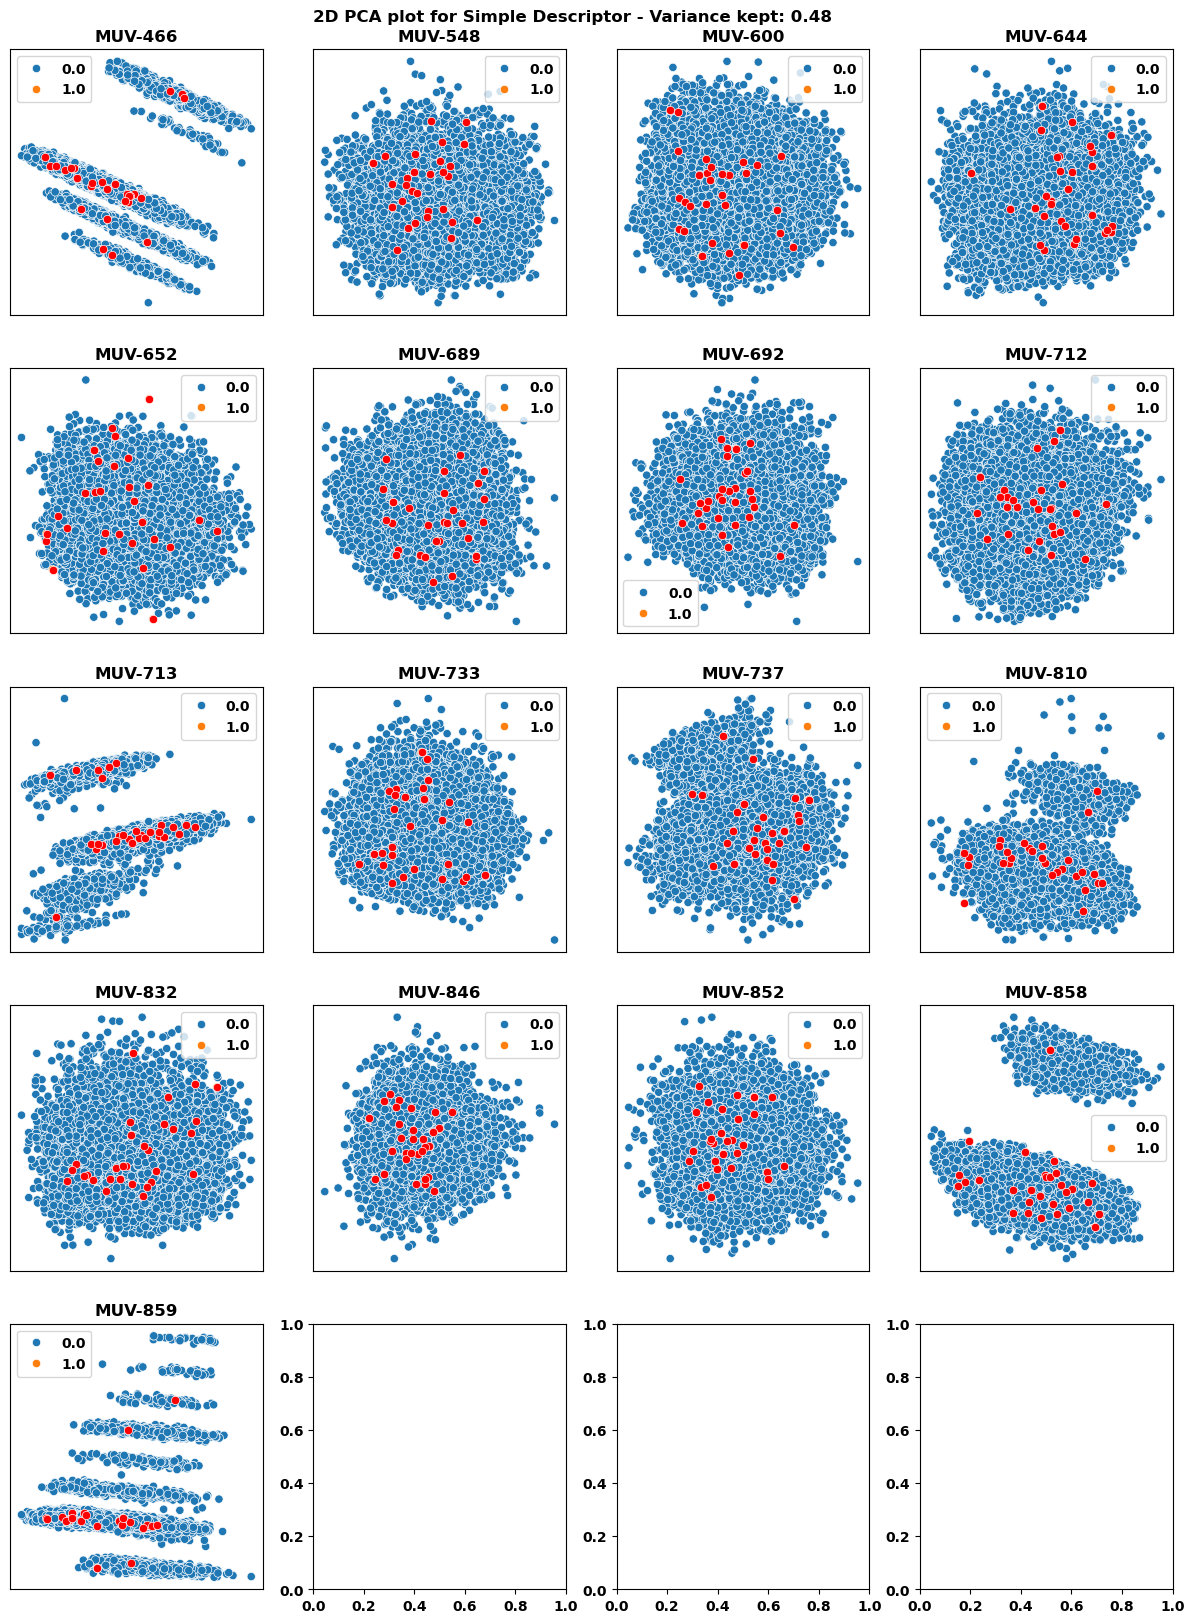

In [171]:
PCA_plot(SimpleDescriptors_df, df, 17, name="Simple Descriptor", save=False)

Here this PCA plot of simple descriptor shows how much the team who has designed the MUV data set has done a great job. Indeed, unactive compounds and active compounds are well scattered and does not particularly cluster into specifics area. However let's notice that not all targets are equivalent. In particular, MUV-466, MUV-713, MUV-858, MUV-859 are very different from just one big cluster but instead are devised into several small clusters. This might lead to more challenging classification or easier. Let's keep that in mind. 

In [21]:
MACCSDescriptor_df = Table_MACCSDescriptor(df)
MACCSDescriptor_df.head()

smiles  MACCS_8  \
mol_id                                                                   
CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C        0   
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1        0   
CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...        0   
CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...        0   
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O        0   

            MACCS_11  MACCS_13  MACCS_14  MACCS_15  MACCS_16  MACCS_17  \
mol_id                                                                   
CID2999678         0         0         0         0         0         0   
CID2999679         0         0         0         0         0         0   
CID2999672         0         0         0         0         0         0   
CID5390002         0         0         0         0         0         0   
CID2999670         0         0         0         0         0         0   

            MACCS_19  MACCS_21  ...  MACCS_156  MACCS_157  MACCS_158  \
mol_id                          ...                                    
CID2999678         0         0  ...          1          0          1   
CID2999679         0         0  ...          1          1          1   
CID2999672         0         0  ...          1          1          1   
CID5390002         0         0  ...          1          0          1   
CID2999670         0         0  ...          1          1          1   

            MACCS_159  MACCS_160  MACCS_161  MACCS_162  MACCS_163  MACCS_164  \
mol_id                                                                         
CID2999678          0          1          1          1          1          1   
CID2999679          1          1          1          1          1          1   
CID2999672          1          1          1          1          1          1   
CID5390002          1          0          1          1          1          1   
CID2999670          1          0          1          1          1          1   

            MACCS_165  
mol_id                 
CID2999678          1  
CID2999679          1  
CID2999672          1  
CID5390002          1  
CID2999670          1  

[5 rows x 149 columns]

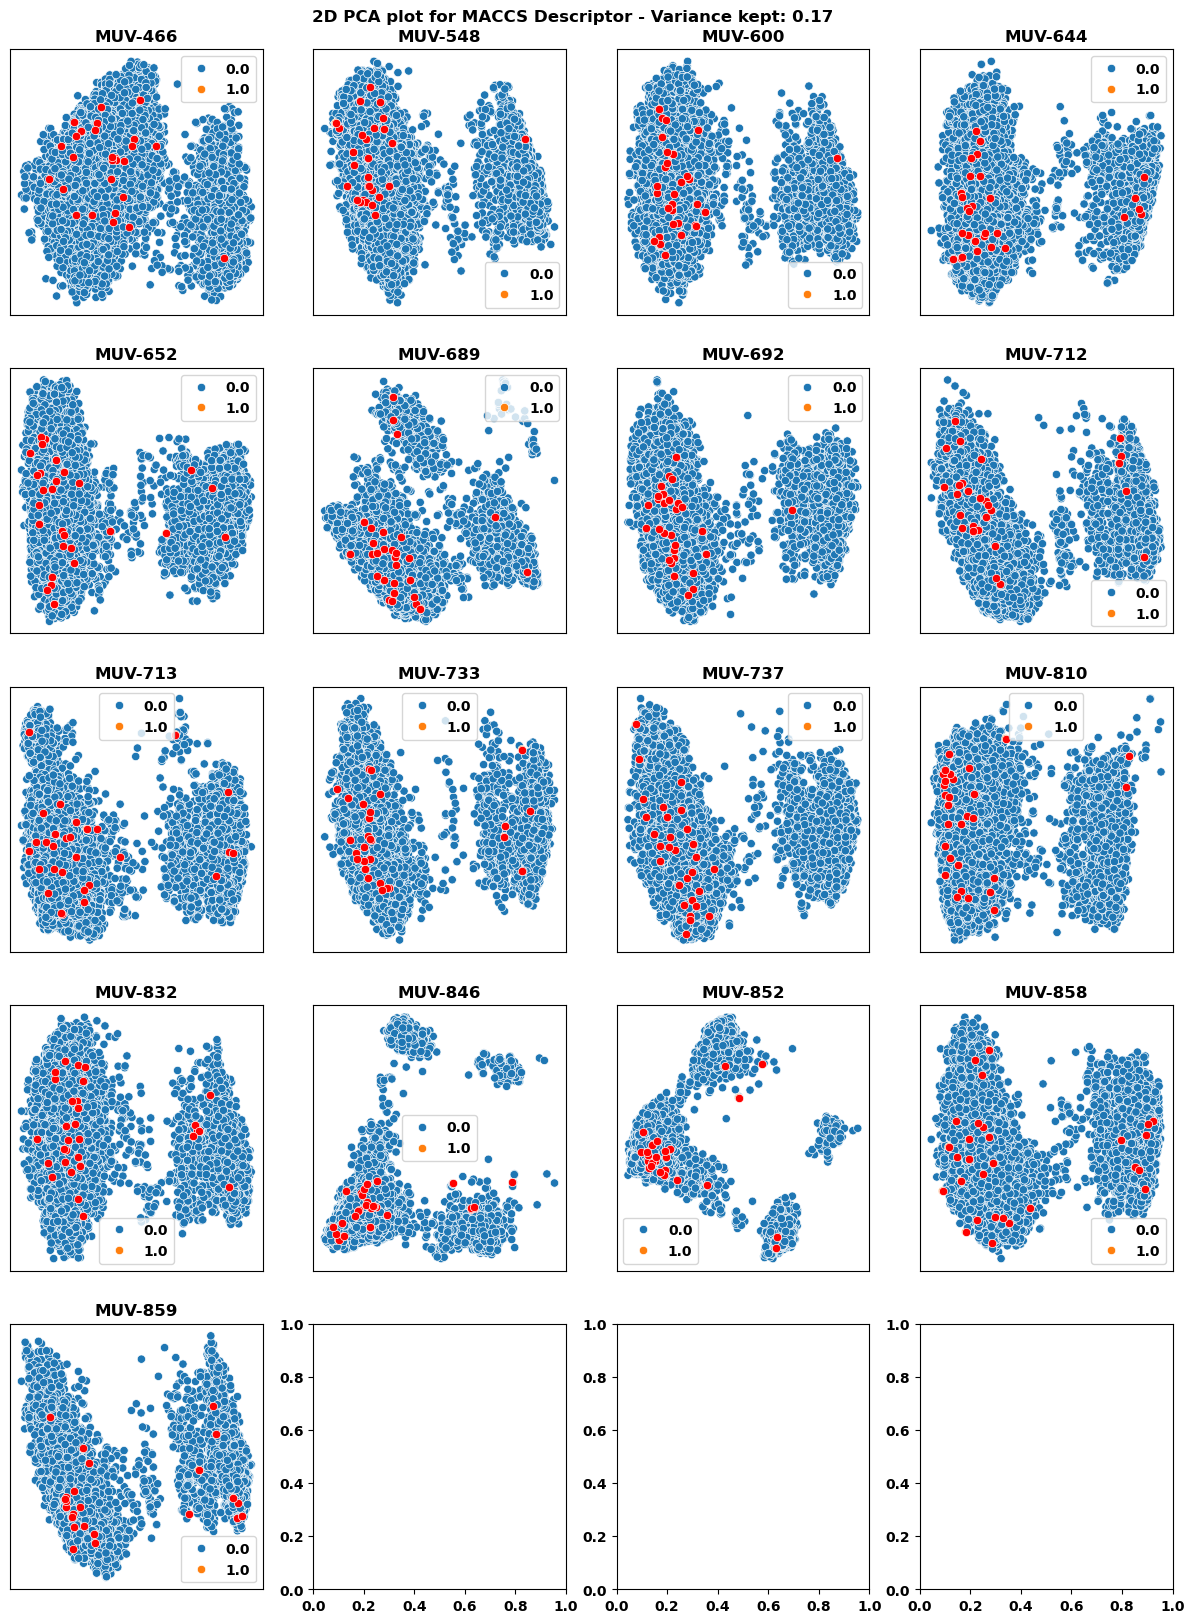

In [172]:
PCA_plot(MACCSDescriptor_df, df, 17, name="MACCS Descriptor", save=False)

In [22]:
ComplexDescriptor_df = Table_ComplexDescriptor(df)
ComplexDescriptor_df.head()

smiles  \
mol_id                                                          
CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C   
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1   
CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...   
CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...   
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O   

            MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
mol_id                                                             
CID2999678          13.523352       13.523352           0.023980   
CID2999679          11.994670       11.994670           0.069697   
CID2999672          13.310867       13.310867           0.395403   
CID5390002          13.109839       13.109839           0.049551   
CID2999670          10.769058       10.769058           0.221343   

            MinEStateIndex       qed        SPS    MolWt  HeavyAtomMolWt  \
mol_id                                                                     
CID2999678        0.023980  0.797490  35.846154  352.522         320.266   
CID2999679       -0.069697  0.691155  10.375000  339.420         322.284   
CID2999672       -1.098380  0.454383  19.147059  455.470         434.302   
CID5390002       -3.026170  0.648384  22.740741  382.441         364.297   
CID2999670       -1.099395  0.666166  11.733333  208.217         196.121   

            ExactMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
mol_id                  ...                                         
CID2999678  352.251464  ...           0             0           0   
CID2999679  339.104148  ...           1             0           0   
CID2999672  455.148121  ...           0             0           0   
CID5390002  382.098728  ...           0             0           1   
CID2999670  208.084792  ...           0             0           0   

            fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
mol_id                                                                  
CID2999678                  0             0            0            0   
CID2999679                  0             0            0            0   
CID2999672                  0             0            0            0   
CID5390002                  0             0            0            0   
CID2999670                  0             0            0            0   

            fr_thiophene  fr_unbrch_alkane  fr_urea  
mol_id                                               
CID2999678             0                 0        0  
CID2999679             0                 0        0  
CID2999672             0                 0        1  
CID5390002             0                 0        0  
CID2999670             0                 0        1  

[5 rows x 203 columns]

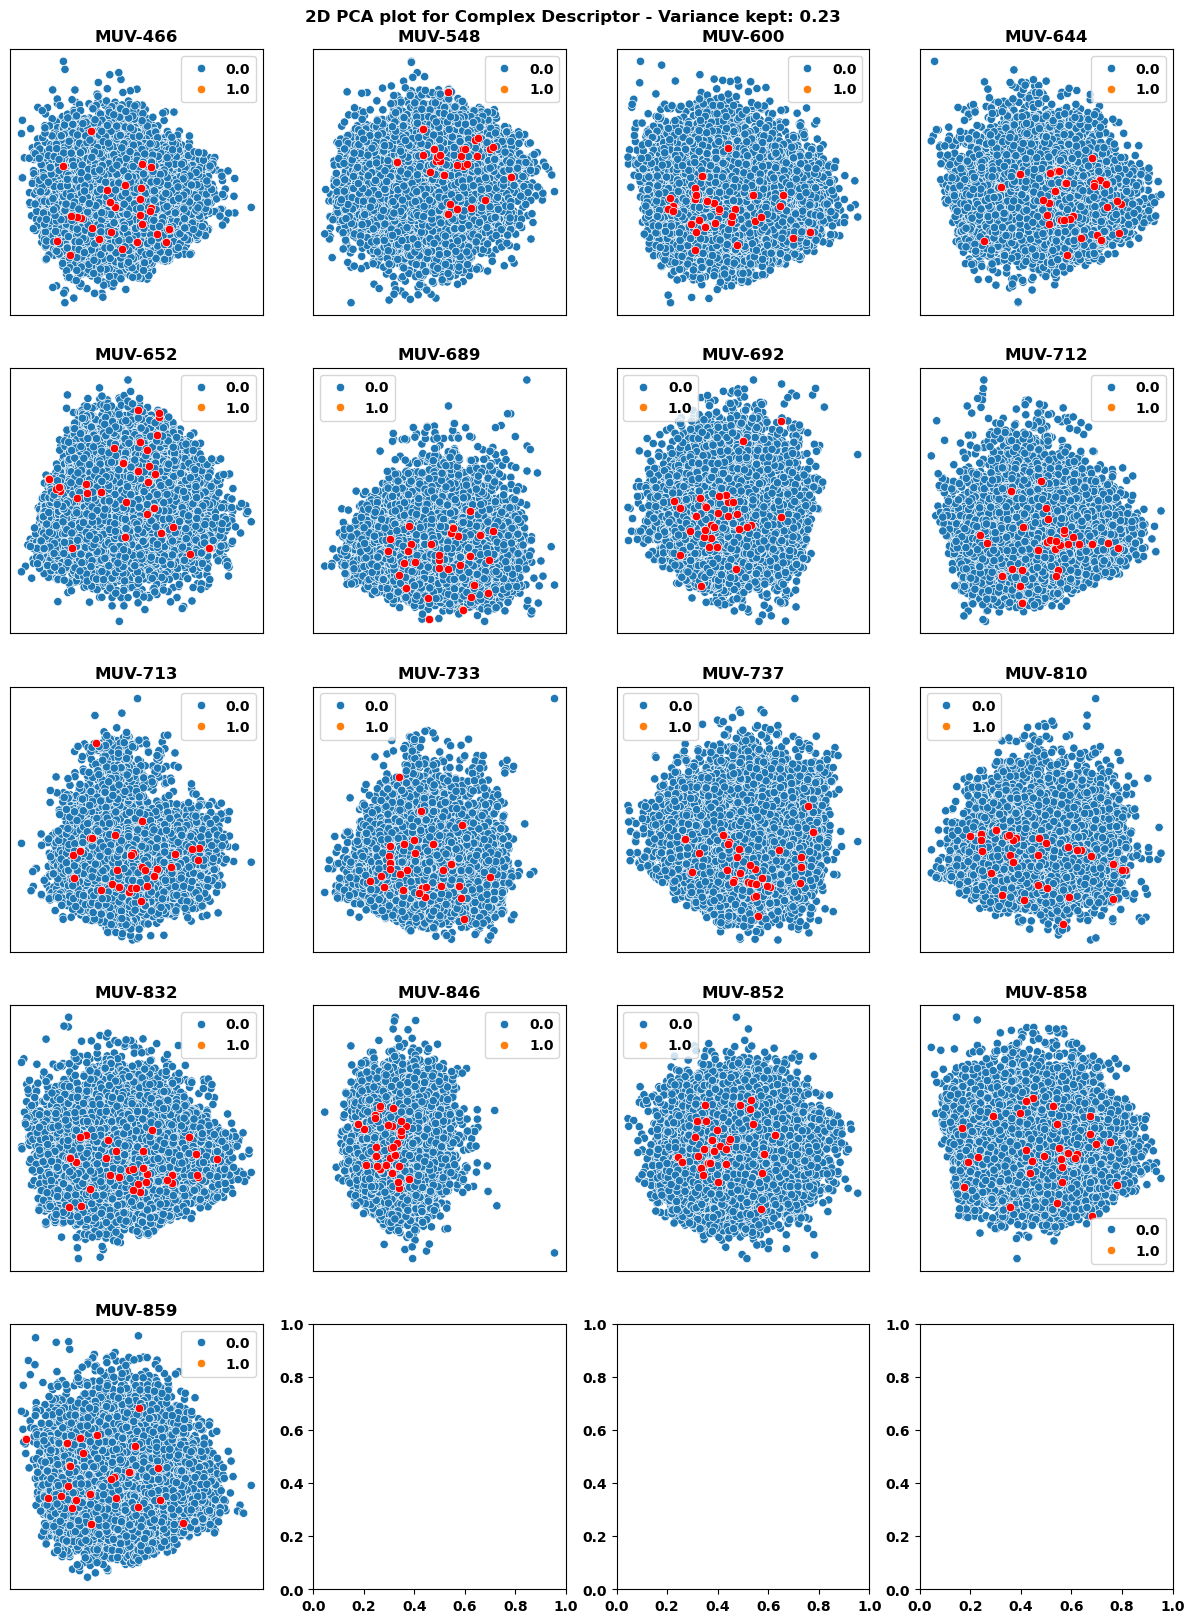

In [173]:
PCA_plot(ComplexDescriptor_df, df, 17, name="Complex Descriptor", save=False)

In [23]:
MergeDescriptor_df = pd.concat([MACCSDescriptor_df, ComplexDescriptor_df.iloc[:,1:], SimpleDescriptors_df.iloc[:,1:]], axis=1)
cor_matrix = MergeDescriptor_df.iloc[:,1:].corr().abs()

corr_rate_threshold = 0.95
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= corr_rate_threshold)]
MergeDescriptor_df = MergeDescriptor_df.drop(MergeDescriptor_df[to_drop], axis = 1)
MergeDescriptor_df.shape

(93087, 307)

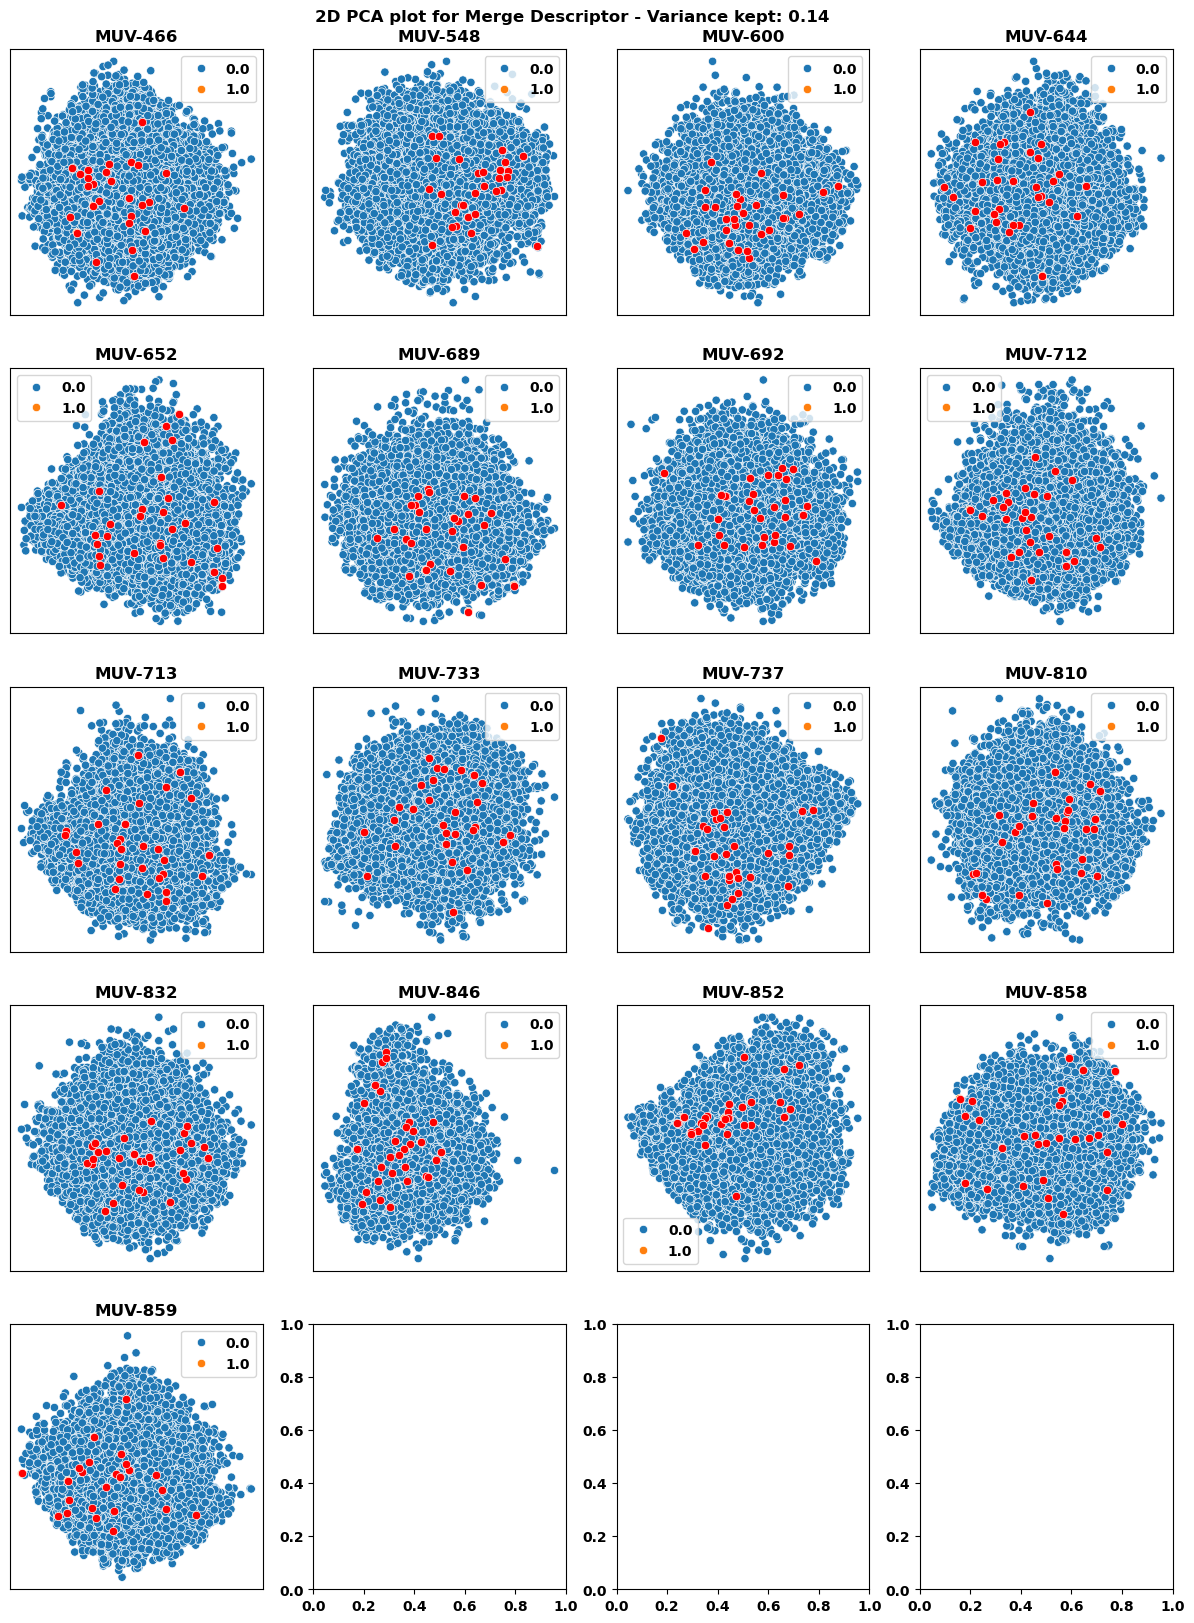

In [174]:
PCA_plot(MergeDescriptor_df, df, 17, name="Merge Descriptor", save=False)

For the MACCS keys, COmplex Descriptor and Merge Descriptor, let's notice that the amount kept with the 2D PCA plot is very small, then the PCA plot  might not be suitable. However, it's interesting to see that active compounds might cluster more with these descriptor representation which migh lead to better classification accuracy. 

### ii) Split of the MUV DataFrame into a dict where each keys are a different target and whose values is a associated dict.
This associated dict has 5 keys:
1. Classification: A dataframe of how the molecule is classified for the target
2. SimpleDescriptor: Simple descriptor dataframe
3. MACCSDescriptor: MACCS descriptor daraframe
4. ComplexDescriptor: Complex descriptor dataframe
5. MergeDescriptor: Merge descriptor dataframe

In [216]:
MUV_dict = {k : {"Classification": df[["smiles", k]][~df[k].isna()]} for k in list(df.keys())[1::]}
for k in list(MUV_dict.keys()):
    MUV_dict[k]["SimpleDescriptor"] = SimpleDescriptors_df.loc[MUV_dict[k]["Classification"].index]
    MUV_dict[k]["MACCSDescriptor"] = MACCSDescriptor_df.loc[MUV_dict[k]["Classification"].index]
    MUV_dict[k]["ComplexDescriptor"] = ComplexDescriptor_df.loc[MUV_dict[k]["Classification"].index]
    MUV_dict[k]["MergeDescriptor"] = MergeDescriptor_df.loc[MUV_dict[k]["Classification"].index]

In [217]:
#For instance
MUV_dict["MUV-466"]["Classification"].head()

smiles  MUV-466
mol_id                                                                
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1      0.0
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O      0.0
CID647485                  O=C(NCc1ccco1)c1csc(Nc2ccccc2Cl)n1      0.0
CID647483   O=C(CN1CCCC1)Nc1ccc(Oc2ccc(NC(=O)CN3CCCC3)cc2)cc1      0.0
CID581177                 CN(C)C1(c2nnnn2-c2ccc(Cl)cc2)CCCCC1      0.0

## c) Splitting Method <a id='DescSplit'></a>

In the litterature [4][7][10][11], there is two most common split encountered for dealing dataset with molecules: 
1. Random Split:
   + The Training and Test split is just made on a random basis. Since the dataset is very unbalanced, a traditional 0.8, 0?2 cannot be applied to the whole dataset but instead, first to the unactive compounds and second to the active compounds. 
2. Scaffold Split:
   + Split made on core structure of molecules, to make the model learn on a Train split with very different molecule than the Test split.
   + It challenges even more the generalization ability of the model. 

Here for example is an example of scaffold structure. This is the core structure of the molecule where side chain, or functional group are removed.

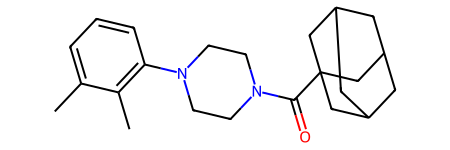

In [9]:
Chem.MolFromSmiles(df.iloc[0,0])

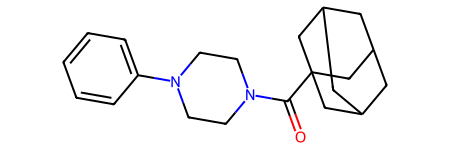

In [10]:
Chem.MolFromSmiles(MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(df.iloc[0,0]), includeChirality=True))

In [80]:
Target_list = list(MUV_dict.keys())

In [ ]:
def Generate_Scaffold(target, dict=MUV_dict):
    '''
    Create the scaffold sets

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).

    Output
    ------
    scaffold_sets(dicct): this is sorted dict, where in first order are the scaffold with the most occurence
    within the MUV dataset. 
    '''
    scaffolds= {}
    for id, sm in enumerate(dict[target]["Classification"]["smiles"].values):
        scaffold = MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(sm), includeChirality=False)
        if scaffold is not None:
            if scaffold not in scaffolds:
                scaffolds[scaffold] = [id]
            else:
                scaffolds[scaffold].append(id)
                
        # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set
        for (scaffold,
             scaffold_set) in sorted(scaffolds.items(),
                                     key=lambda x: (len(x[1]), x[1][0]),
                                     reverse=True)
    ]
    return scaffold_sets

def Scaffold_Splitter(target, dict=MUV_dict, frac_train=0.8):
    '''
    Output the training index and the test index for the scaffold splitting method

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).
    frac_train(float): training fraction. 0 < frac_train < 1

    Output
    ------
    train_inds(ndarray): training index in regard of a specific target
    valid_inds(ndarray): valid index in regard of a specific target
    '''
    
    scaffold_sets = Generate_Scaffold(target, MUV_dict)
    
    if not (0 < frac_train < 1):
        raise print(f"frac_train must be within 0 and 1 excluded. Here {frac_train} was provided")
        
    frac_val = 1 - frac_train
    numb_mol = len(dict[target]["Classification"])
    train_cutoff = frac_train * numb_mol
    train_inds = []
    valid_inds = []

    for scaffold_set in scaffold_sets:
        if len(train_inds) + len(scaffold_set) > train_cutoff:
            valid_inds += scaffold_set
        else:
            train_inds += scaffold_set
    return np.array(train_inds), np.array(valid_inds)

def Noisy_Scaffol_Splitter(target, dict=MUV_dict, frac_train=0.8, iteration = 1, 
                           noise_dict = {"train to valid" : {"0":0.1, "1": 0.3},
                                         "valid to train" : {"0":0.1, "1":0}}):
    '''
    Output the training index and the test index for the noisy scaffold splitting method
    The noisy scaffold splitting is actually to make the scaffold splitting less challenging.
    It does not have to be used but can be insightful for training purposes when one want something
    slightly more challenging than the Random split but less difficult than scaffold split. 

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).
    frac_train(float): training fraction. 0 < frac_train < 1
    iteration(int): the number of iteration of noisy scaffold split to be tested to get a more a robust 
        prediction of the model accuracy.
    noise_dict(dict): 'train to valid' key is composed of another dict with keys 0 and 1. 
        It tells the fraction of unvalid and valid compound one want to move from the training split
        to the test split. The opposite apply for the 'valid to train' key. 

    Output
    ------
    train_inds(ndarray): training index in regard of a specific target
    valid_inds(ndarray): valid index in regard of a specific target
    '''
    train_inds, valid_inds = Scaffold_Splitter(target, dict=MUV_dict, frac_train=0.8)
    train_inds_0 = train_inds[(dict[target]["Classification"].iloc[train_inds,1]==0)]
    train_inds_1 = train_inds[(dict[target]["Classification"].iloc[train_inds,1]==1)]
    valid_inds_0 = valid_inds[(dict[target]["Classification"].iloc[valid_inds,1]==0)]
    valid_inds_1 = valid_inds[(dict[target]["Classification"].iloc[valid_inds,1]==1)]
    train_index_list, val_index_list = [], []
    for _ in range(iteration):
        remove_train_0 = [i for i in train_inds_0 if np.random.rand() < noise_dict["train to valid"]["0"]]
        remove_train_1 = [i for i in train_inds_1 if np.random.rand() < noise_dict["train to valid"]["1"]]
        remove_valid_0 = [i for i in valid_inds_0 if np.random.rand() < noise_dict["valid to train"]["0"]]
        remove_valid_1 = [i for i in valid_inds_1 if np.random.rand() < noise_dict["valid to train"]["1"]]
        train_index = [i for i in train_inds_0 if i not in remove_train_0] 
        train_index += [i for i in train_inds_1 if i not in remove_train_1]
        train_index += remove_valid_0 + remove_valid_1
        np.random.shuffle(train_index)
        train_index_list.append(train_index)
        valid_index = [i for i in valid_inds_0 if i not in remove_valid_0]
        valid_index += [i for i in valid_inds_1 if i not in remove_valid_1]
        valid_index += remove_train_0 + remove_train_1
        np.random.shuffle(valid_index)
        val_index_list.append(valid_index)
    return train_index_list, val_index_list

def RandomSplit(target, dict, frac_train, iteration):
    '''
    Output the training index and the test index for the random splitting method

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).
    frac_train(float): training fraction. 0 < frac_train < 1
    iteration(int): the number of iteration of random split oto be tested to get a more a robust prediction
        of the model accuracy. 

    Output
    ------
    train_index_list(list(ndarrat): training index in regard of a specific target
    val_index_list(ndarray): valid index in regard of a specific target
    '''
    neg_index = np.arange(dict[target]["Classification"].shape[0])[(dict[target]["Classification"].iloc[:,1]==0)]
    pos_index = np.arange(dict[target]["Classification"].shape[0])[(dict[target]["Classification"].iloc[:,1]==1)]
    train_index_list, val_index_list = [], []
    for _ in range(iteration):
        train_index_0, val_index_0 = train_test_split(neg_index,train_size=frac_train, shuffle=True)
        train_index_1, val_index_1 = train_test_split(pos_index,train_size=frac_train, shuffle=True)
        train_index = np.concatenate((train_index_0, train_index_1))
        np.random.shuffle(train_index)
        train_index_list.append(train_index)
        val_index = np.concatenate((val_index_0, val_index_1))
        np.random.shuffle(val_index)
        val_index_list.append(val_index)
    return train_index_list, val_index_list 

## d) Model <a id='DescModel'></a>
For descriptor modeling, a decision tree algorithm is pretty suitable as it is appropriate for several features in input to perform classification task. In addition decision tree as the advantage to be more easier to fine tune than Multi layer perceptrons for instance.
As for a first model, nothing can really be expected, and since the data set is very unbalanced, many difficulty may occure and the simplicity of implementation is therefore the safer way to get result. 

Several model has been tested and several way to present the accuracy result as well. 
For the accuracy, the most common way for the MUV dataset is to use ROC_AUC measure [4][7][10][11]. This accuracy focus on the wrong classification, and therefore expecially on wrong classification of positive compound (as the dataset is unbalanced). To understand the ROC_AUC, refers to [5]. 
1. Random Forest. This is the first model implemented. A parameter called 'class_weight' allow to select the option 'balanced'.
   + The Random forest happen to be inefficient with a ROC_AUC of 0.5 for the test split.
   + For learning purposes, the confusion matrix has been plotted.
2. XGBoost. With a heavy fine tunning, it has been able to reach a ROC_AUC of 0.6 for a scaffold split.
3. ImbXGBoost. This version is an unbalanced version of XGBoost which rely on a sepcific package [8]. This package has been used after the realisation that the focal loss could be even more interesting than the traditional binary cross entropy [7].
The focal loss is written as follow:
$$FL(y, p) = −[𝑦(1 −𝑝)^γ𝑙𝑜𝑔(𝑝) + (1 − 𝑦) 𝑝^γ 𝑙𝑜𝑔(1 − 𝑝)]$$

It is especially used with unbalanced data set where gamma is a specific parameter to fine tune. It is adviced to start with $γ = 2$ and then decrease or increase it based on the observation. Note, if $γ = 1$ then it is the classic binary cross entropy. 

### i) Random Forest

In [ ]:
def Grid_search_RandomForest(target_L, descriptor, dict=MUV_dict, frac_train=0.8, iteration = 1, 
                          splitter="Scaffold", 
                          noise_dict={"train to valid" : {"0":0.1, "1": 0.3}, 
                                      "valid to train" : {"0":0.1, "1":0}}, 
                          printing=True):
    """
    Return Train accuracy and Test Accuracy for the RandomForest model. 
    
    Parameters
    ---------
    target_L(list(string)): List of target to classify, Must be in MUV_dict.keys()
    descriptor(string): Descriptor to use, Must be: SimpleDescriptor, MACCSDescriptor, 
         ComplexDescriptor or MergeDescriptor
    dict(dict): MUV_dict created before
    frac_train(float): fraction of training split
    iteration(int): for random split or noisy scaffold split for more robust estimation of classifier accuracy. 
    splitter(string): 'Scaffold' or 'Random'
    noise_dict(dict): please enter a dict as specified in the example value. 
    printing(bool): whether or not to print the result or just relie on the return dict. 

    Output
    -------
    train_acc_all: list of training accuracy for each target. 
    test_acc_all: list of test accuracy for each target. 
    """
    
    if np.all([target not in list(MUV_dict.keys()) for target in target_L]):
        raise print(f"Target does not exist, please enter a target in: {list(MUV_dict.keys())}")
    if descriptor not in ["SimpleDescriptor", "MACCSDescriptor", "ComplexDescriptor", "MergeDescriptor"]:
        raise print("Descriptor does not exist, please enter a descriptor in ['SimpleDescriptor', 'MACCSDescriptor', 'ComplexDescriptor', 'MergeDescriptor']")
    if splitter not in ["Scaffold", "Random"]:
        raise print("splitter does not existe, please enter a splitter in ['Scaffold', 'Random']")
    
    for target in target_L:
        if splitter == "Random":
            train_index_list, test_index_list = RandomSplit(target, dict, frac_train, iteration)
        elif splitter == "Scaffold":
            train_index_list, test_index_list = Noisy_Scaffol_Splitter(target, dict, frac_train, iteration, noise_dict)
        train_acc_all = []
        test_acc_all = []
        X = StandardScaler().fit_transform(dict[target][descriptor].iloc[:,1:].values)
        y = dict[target]["Classification"].iloc[:,1].values
        for train_index, test_index in list(zip(train_index_list, test_index_list)): 
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = y[train_index], y[test_index]
            
            rfc = RandomForestClassifier(class_weight="balanced", n_estimators=500)
            rfc.fit(X_train, y_train)
            
            # Report prediction accuracy for this fold
            # TPR and FPR are prefered as there is a very few number of true value
            train_conf_matrix = confusion_matrix(y_train, rfc.predict(X_train)) 
            #'[[TN,FP]'
            #'[[FN,TP]]'
            
            train_acc = {"TPR": train_conf_matrix[1,1] / (train_conf_matrix[1,1] + train_conf_matrix[1,0]),
                         "FPR": train_conf_matrix[0,1] / (train_conf_matrix[0,1] + train_conf_matrix[0,0])}
            train_acc_all.append(train_acc)
            
            test_conf_matrix = confusion_matrix(y_test, rfc.predict(X_test))
            test_acc = {"TPR": test_conf_matrix[1,1] / (test_conf_matrix[1,1] + test_conf_matrix[1,0]),
                         "FPR": test_conf_matrix[0,1] / (test_conf_matrix[0,1] + test_conf_matrix[0,0])}
            test_acc_all.append(test_acc)
            if printing:
                print("Accuracy for target:", target)
                print("Train accuracy:", train_acc)
                print("Train ROC_AUC score:", roc_auc_score(y_train, rfc.predict(X_train)))
                print("Test accuracy:", test_acc)
                print("Test ROC_AUC score:", roc_auc_score(y_test, rfc.predict(X_test)))
                plt.figure()
                sns.heatmap(train_conf_matrix, annot=True)
                plt.figure()
                sns.heatmap(test_conf_matrix, annot=True)
    return train_acc_all, test_acc_all

Accuracy for target: MUV-466
Train accuracy: {'TPR': 1.0, 'FPR': 8.43810648890389e-05}
Train ROC_AUC score: 0.9999578094675554
Test accuracy: {'TPR': 0.0, 'FPR': 0.0}
Test ROC_AUC score: 0.5
Accuracy for target: MUV-548
Train accuracy: {'TPR': 1.0, 'FPR': 8.500510030601836e-05}
Train ROC_AUC score: 0.999957497449847
Test accuracy: {'TPR': 0.0, 'FPR': 0.0}
Test ROC_AUC score: 0.5
Accuracy for target: MUV-600
Train accuracy: {'TPR': 1.0, 'FPR': 0.00017009695526450075}
Train ROC_AUC score: 0.9999149515223678
Test accuracy: {'TPR': 0.0, 'FPR': 0.0}
Test ROC_AUC score: 0.5


([{'TPR': 1.0, 'FPR': 0.00017009695526450075}], [{'TPR': 0.0, 'FPR': 0.0}])

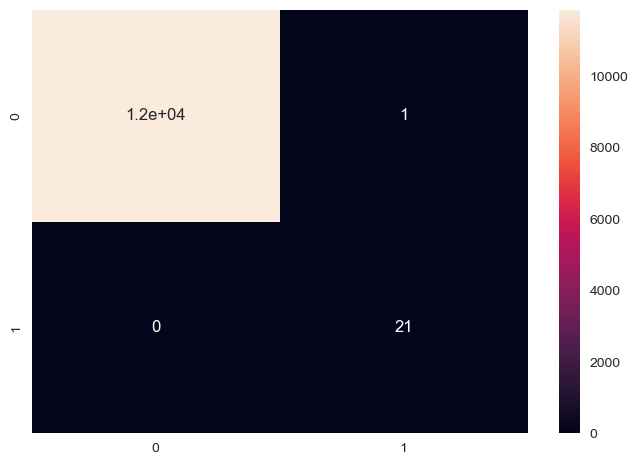

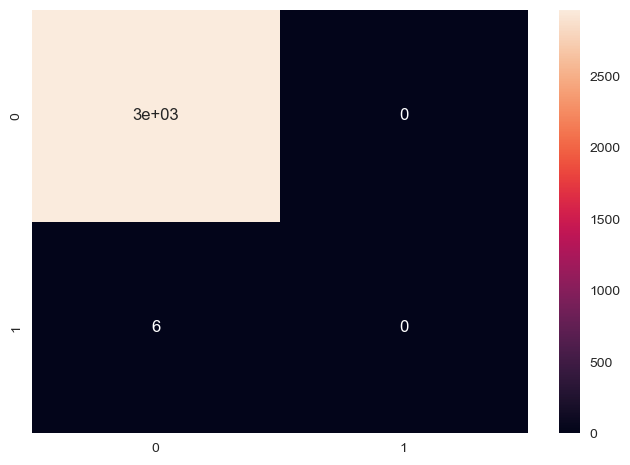

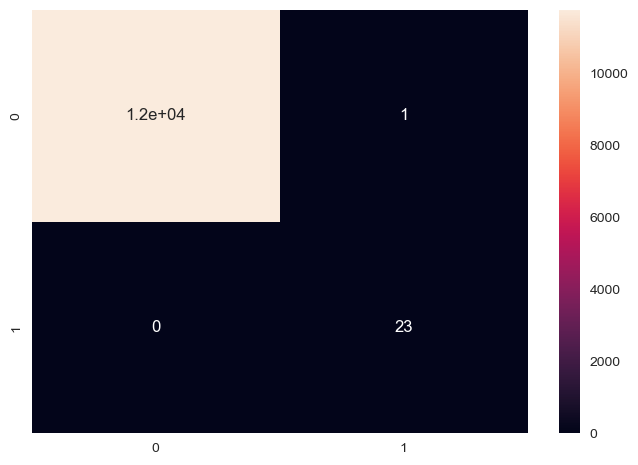

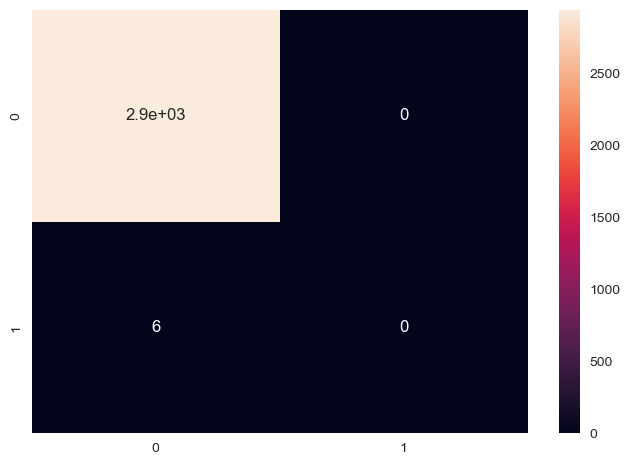

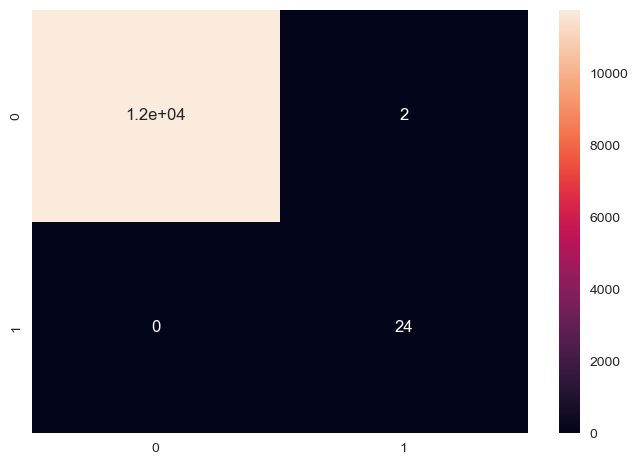

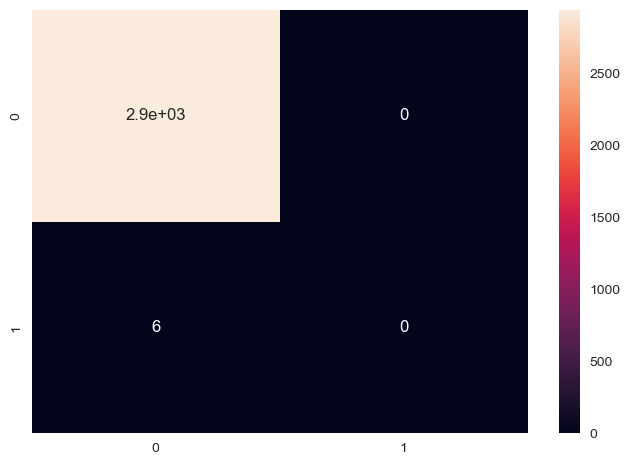

In [81]:
# Here the first 3 targets are tested. the MACCS Descriptor is used for illustration. Here the Random splitter is tested. 
Grid_search_RandomForest(Target_list[0:3], descriptor="MACCSDescriptor", dict=MUV_dict, frac_train=0.8, iteration = 1,
                      splitter="Random",
                      noise_dict = {"train to valid" : {"0":0, "1": 0}, 
                                    "valid to train" : {"0":0, "1": 0}}, 
                      printing=True)

The RandomForest is very prone to overfitting. The number of trees should be reduced and the depth as well. 
The confusion matrix plot allows to realize that active compounds are always wrongly classified which was expected from an unbalanced data set. And this even thouth the use of class_weight = 'balanced'. 
A grid search on the parameter could be tested but let see if an XGBoost would be better.

### ii) XGBoost

In [395]:
def Grid_search_XGBoost(target_L, descriptor, dict=MUV_dict, frac_train=0.8, iteration = 1, splitter="Scaffold",
                     noise_dict = {"train to valid" : {"0":0.1, "1": 0.3}, 
                                   "valid to train" : {"0":0.1, "1":0}}, printing=True, 
                       XGB_param={"n_estimators": 200, "max_depth":3, "subsample":0.9, "colsample_bytree":0.7, 
                                  "eval_metric":roc_auc_score, 
                                  "use_label_encoder":False, "gamma":0,
                                  "eta":0.01,
                                  "min_child_weight":1000}):
    
    """
    Return Train accuracy and Test Accuracy for the XGBoost model. 
    
    Parameters
    ---------
    target_L(list(string)): List of target to classify, Must be in MUV_dict.keys()
    descriptor(string): Descriptor to use, Must be: SimpleDescriptor, MACCSDescriptor, 
         ComplexDescriptor or MergeDescriptor
    dict(dict): MUV_dict created before
    frac_train(float): fraction of training split
    iteration(int): for random split or noisy scaffold split for more robust estimation of classifier accuracy. 
    splitter(string): 'Scaffold' or 'Random'
    noise_dict(dict): please enter a dict as specified in the example value. 
    printing(bool): whether or not to print the result or just relie on the return dict. 
    XGB_param(dict): must have the same shape as the one provided as default value. 

    Output
    -------
    train_acc_all: list of training accuracy for each target. 
    test_acc_all: list of test accuracy for each target. 
    """
    
    if np.all([target not in list(MUV_dict.keys()) for target in target_L]):
        raise print(f"Target does not exist, please enter a target in: {list(MUV_dict.keys())}")
    if descriptor not in ["SimpleDescriptor", "MACCSDescriptor", "ComplexDescriptor", "MergeDescriptor"]:
        raise print("Descriptor does not exist, please enter a descriptor in ['SimpleDescriptor', 'MACCSDescriptor', 'ComplexDescriptor', 'MergeDescriptor']")
    if splitter not in ["Scaffold", "Random"]:
        raise print("splitter does not existe, please enter a splitter in ['Scaffold', 'Random']")
        
    Target_acc_dict = {}
    for target in tqdm(target_L, leave=True):
        if splitter == "Random":
            train_index_list, test_index_list = RandomSplit(target, dict, frac_train, iteration)
        train_index_list, test_index_list = Noisy_Scaffol_Splitter(target, dict, frac_train, iteration, noise_dict)
        train_acc_all = []
        test_acc_all = []
        X = StandardScaler().fit_transform(dict[target][descriptor].iloc[:,1:].values)
        y = dict[target]["Classification"].iloc[:,1].values.astype(int)
        for train_index, test_index in list(zip(train_index_list, test_index_list)): 
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = y[train_index], y[test_index]

            XGB_param["scale_pos_weight"] = len(y)/np.sum(y==1)
            xgbc = XGBClassifier(n_estimators=XGB_param["n_estimators"], 
                                 max_depth=XGB_param["max_depth"], 
                                 subsample=XGB_param["subsample"], 
                                 colsample_bytree=XGB_param["colsample_bytree"], 
                                 eval_metric=XGB_param["eval_metric"], 
                                 use_label_encoder=XGB_param["use_label_encoder"], 
                                 scale_pos_weight=XGB_param["scale_pos_weight"], 
                                 gamma=XGB_param["gamma"],
                                 eta=XGB_param["eta"],
                                 min_child_weight=XGB_param["min_child_weight"],
                                objective="binary:logistic")
            xgbc.fit(X_train, y_train)

            train_acc_all.append(roc_auc_score(y_train, xgbc.predict(X_train)))
            test_acc_all.append(roc_auc_score(y_test, xgbc.predict(X_test)))
        Target_acc_dict.update({target: {"Train_AUC": np.mean(train_acc_all),
                                         "Test_AUC": np.mean(test_acc_all)}})
        
    acc_df = pd.DataFrame(Target_acc_dict).transpose()
    if printing:
        figure, axes = plt.subplots(2, 1, figsize=(15,10))
        axes = axes.flatten()
        sns.barplot(acc_df, x=acc_df.index, y="Train_AUC", ax=axes[0])
        axes[0].set(xlabel='Target', ylabel='Train AUC')
        sns.barplot(acc_df, x=acc_df.index, y="Test_AUC", ax=axes[1])
        axes[1].set(xlabel='Target', ylabel='Test AUC')
        print(f"Overall AUC score among {len(target_L)} target(s):\n {acc_df.mean(axis=0)}")
    return acc_df

All target are tested, the splitter scaffold is used. 
The parameteres used for XGBoost is the fruit of a heavy tuning. It has been performed by successive iteration.
Only 3 first targets were tested (as it already take 35 s to run). And parameters were modified based on the result obtained. For instance, if it was overfitting too much, the max_depth was reduced, or n_estimator was decreased. 
min_child_weight happen to be an important parameter as well to reduce overfitting as it prevent a node in a tree to be further split if the sum of the weight in this node (the sum of weight associated to each sample in this node) does not reach min_child_weight. 
For a more comprehensive understanding of XGBoost parameters, please refer to: https://xgboost.readthedocs.io/en/stable/parameter.html

100%|██████████| 17/17 [03:32<00:00, 12.51s/it]


Overall AUC score among 17 target(s):
 Train_AUC    0.940160
Test_AUC     0.606743
dtype: float64


Train_AUC  Test_AUC
MUV-466   0.949823  0.455496
MUV-548   0.897762  0.778985
MUV-600   0.922709  0.610998
MUV-644   0.943973  0.659247
MUV-652   0.951975  0.522727
MUV-689   0.919309  0.687479
MUV-692   0.904061  0.603204
MUV-712   0.951771  0.627210
MUV-713   0.937780  0.533029
MUV-733   0.910128  0.510093
MUV-737   0.953546  0.570838
MUV-810   0.962029  0.678694
MUV-832   0.959166  0.622996
MUV-846   0.943526  0.696787
MUV-852   0.969434  0.668900
MUV-858   0.931406  0.560954
MUV-859   0.974323  0.526994

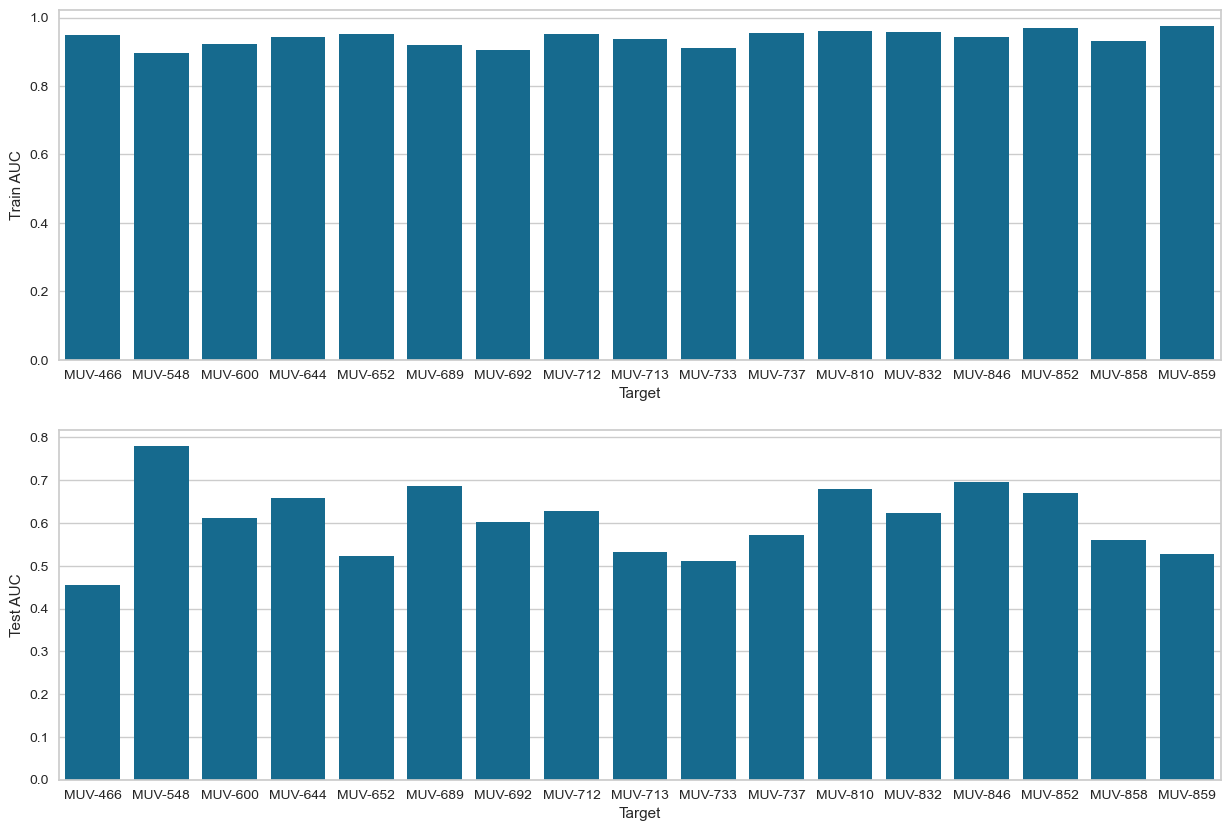

In [747]:
Grid_search_XGBoost(Target_list, descriptor="MergeDescriptor", dict=MUV_dict, frac_train=0.8, iteration = 1, splitter="Scaffold",
                     noise_dict = {"train to valid" : {"0":0, "1": 0}, 
                                   "valid to train" : {"0":0, "1":0}}, printing=True, 
                       XGB_param={"n_estimators": 200, "max_depth":3, "subsample":0.9, "colsample_bytree":0.7, "eval_metric":roc_auc_score, 
                                 "use_label_encoder":False, "gamma":0,
                                "eta":0.01,
                                "min_child_weight":1000})

XGBoost is already better than a simple random forest and this even considering the use of the Scaffold Splitter which is more challenging than the Random split. However, let's consider the focal loss which might be even more effective to adress the unbalance data set problem. 

### iii) Imbalanced XGboost

In [436]:
import warnings
warnings.filterwarnings('ignore') 
# To supress warnings when running ImbXGBoost 

def Grid_search_ImbXGBoost(target_L, descriptor, dict=MUV_dict, frac_train=0.8, iteration = 1, splitter="Scaffold",
                     noise_dict = {"train to valid" : {"0":0.1, "1": 0.3}, 
                                   "valid to train" : {"0":0.1, "1":0}}, printing=True, 
                       XGB_param={"n_estimators": 200, "max_depth":3, "eval_metric":roc_auc_score,
                                "eta":0.01, "focal_gamma":2}):
    """
    Return Train accuracy and Test Accuracy for the ImbXGBoost model. 
    
    Parameters
    ---------
    target_L(list(string)): List of target to classify, Must be in MUV_dict.keys()
    descriptor(string): Descriptor to use, Must be: SimpleDescriptor, MACCSDescriptor, 
         ComplexDescriptor or MergeDescriptor
    dict(dict): MUV_dict created before
    frac_train(float): fraction of training split
    iteration(int): for random split or noisy scaffold split for more robust estimation of classifier accuracy. 
    splitter(string): 'Scaffold' or 'Random'
    noise_dict(dict): please enter a dict as specified in the example value. 
    printing(bool): whether or not to print the result or just relie on the return dict. 
    XGB_param(dict): must have the same shape as the one provided as default value. 

    Output
    -------
    train_acc_all: list of training accuracy for each target. 
    test_acc_all: list of test accuracy for each target. 
    """
    
    if np.all([target not in list(MUV_dict.keys()) for target in target_L]):
        raise print(f"Target does not exist, please enter a target in: {list(MUV_dict.keys())}")
    if descriptor not in ["SimpleDescriptor", "MACCSDescriptor", "ComplexDescriptor", "MergeDescriptor"]:
        raise print("Descriptor does not exist, please enter a descriptor in ['SimpleDescriptor', 'MACCSDescriptor', 'ComplexDescriptor', 'MergeDescriptor']")
    if splitter not in ["Scaffold", "Random"]:
        raise print("splitter does not existe, please enter a splitter in ['Scaffold', 'Random']")
        
    Target_acc_dict = {}
    for target in tqdm(target_L, leave=True):
        if splitter == "Random":
            train_index_list, test_index_list = RandomSplit(target, dict, frac_train, iteration)
        train_index_list, test_index_list = Noisy_Scaffol_Splitter(target, dict, frac_train, iteration, noise_dict)
        train_acc_all = []
        test_acc_all = []
        X = StandardScaler().fit_transform(dict[target][descriptor].iloc[:,1:].values)
        y = dict[target]["Classification"].iloc[:,1].values.astype(int)
        for train_index, test_index in list(zip(train_index_list, test_index_list)): 
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = y[train_index], y[test_index]

            imb_xgbc = imb_xgb(num_round=XGB_param["n_estimators"], 
                           max_depth=XGB_param["max_depth"],
                           eval_metric=XGB_param["eval_metric"],
                           verbosity=0,
                           eta=XGB_param["eta"],
                           special_objective='focal',
                          focal_gamma=XGB_param["focal_gamma"])
            
            imb_xgbc.fit(X_train, y_train)

            train_acc_all.append(roc_auc_score(y_train, imb_xgbc.predict(X_train)))
            test_acc_all.append(roc_auc_score(y_test, imb_xgbc.predict(X_test)))
        Target_acc_dict.update({target: {"Train_AUC": np.mean(train_acc_all),
                                         "Test_AUC": np.mean(test_acc_all)}})
        
    acc_df = pd.DataFrame(Target_acc_dict).transpose()
    if printing:
        figure, axes = plt.subplots(2, 1, figsize=(15,10))
        axes = axes.flatten()
        sns.barplot(acc_df, x=acc_df.index, y="Train_AUC", ax=axes[0])
        axes[0].set(xlabel='Target', ylabel='Train AUC')
        sns.barplot(acc_df, x=acc_df.index, y="Test_AUC", ax=axes[1])
        axes[1].set(xlabel='Target', ylabel='Test AUC')
        print(f"Overall AUC score among {len(target_L)} target(s):\n {acc_df.mean(axis=0)}")
    return acc_df

Imb_xgb has been built on XGBClassifier but with less parameters [8]. There is therefore less freedom on tunning but it is easier to focus on certain parameters. The goal is mainly to test the superiority of the focal loss. 
After having determined the best parameters on a few exmple and realize that ImbXGboost was better than the traditional XGBoost, the final simulation has been runned: 
+ Iteration on each Descriptor,
+ for each targets,
+ for Scaffold,
+ 3 times for Random splitter to get a more robust prediction of the performance of the model and not just relie on luck (or bad luck) for the random split.

The results for this model are not display right after the model training but in the later part as it concludes the Descriptor modeling part.  

In [469]:
splitter_L = ["Scaffold", "Random"]
descriptor_L = ["SimpleDescriptor", "MACCSDescriptor", "ComplexDescriptor", "MergeDescriptor"]
Accuracy_dict = {"Train_AUC": [], "Test_AUC": [], "Target": [], "Splitter": [], "Descriptor": []}
for splitter in tqdm(splitter_L, leave=True):
    for descriptor in tqdm(descriptor_L, leave=True):
        if splitter == "Scaffold":
            iteration = 1
        else:
            iteration = 3
        
        acc_df = Grid_search_ImbXGBoost(Target_list, descriptor=descriptor, dict=MUV_dict, frac_train=0.8, iteration = iteration, splitter=splitter,
                             noise_dict = {"train to valid" : {"0":0, "1": 0}, 
                                           "valid to train" : {"0":0, "1":0}}, printing=False, 
                               XGB_param={"n_estimators": 500, "max_depth":8, "eval_metric":"auc",
                                        "eta":0.1, "focal_gamma":1.4})
        Accuracy_dict["Train_AUC"] += list(acc_df["Train_AUC"].values)
        Accuracy_dict["Test_AUC"] += list(acc_df["Test_AUC"].values)
        Accuracy_dict["Target"] += list(acc_df.index)
        Accuracy_dict["Splitter"] += [splitter for i in range(acc_df.shape[0])]
        Accuracy_dict["Descriptor"] += [descriptor for i in range(acc_df.shape[0])]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                              | 1/17 [00:14<03:52, 14.54s/it]

 12%|█████████▊                                                                         | 2/17 [00:28<03:31, 14.10s/it]

 18%|██████████████▋                                                                    | 3/17 [00:42<03:19, 14.23s/it]

 24%|███████████████████▌                                                               | 4/17 [00:58<03:13, 14.86s/it]

 29%|████████████████████████▍                                                          | 5/17 [01:14<03:03, 15.27s/it]

 35%|█████████████████████████████▎                                                     | 6/17 [01:28<02:43, 14.85s/it]

 41%|███████████████████████████

In [236]:
if os.path.exists("./Dataset_MUV/ImbXGBoost_Accuracy.csv"):
    Accuracy_df = pd.read_csv("./Dataset_MUV/ImbXGBoost_Accuracy.csv", )
    Accuracy_df = Accuracy_df.iloc[:,1:]
else:
    Accuracy_df = pd.DataFrame(Accuracy_dict)
    Accuracy_df.to_csv("./Dataset_MUV/ImbXGBoost_Accuracy.csv")

## e) Result <a id='DescResult'></a>
Let's plot the result for the ImbXGboost and draw conclusions out of this model as it happened to be the most effective in term of classification accuracy. 
### i) Selection of the best Descriptor

In [237]:
Accuracy_df

Train_AUC  Test_AUC   Target  Splitter        Descriptor
0     0.891145  0.704428  MUV-466  Scaffold  SimpleDescriptor
1     0.928665  0.490324  MUV-548  Scaffold  SimpleDescriptor
2     0.898399  0.549389  MUV-600  Scaffold  SimpleDescriptor
3     0.937678  0.613870  MUV-644  Scaffold  SimpleDescriptor
4     0.786797  0.714585  MUV-652  Scaffold  SimpleDescriptor
..         ...       ...      ...       ...               ...
131   0.980113  0.634444  MUV-832    Random   MergeDescriptor
132   0.970636  0.984529  MUV-846    Random   MergeDescriptor
133   0.972652  0.754819  MUV-852    Random   MergeDescriptor
134   0.935865  0.785920  MUV-858    Random   MergeDescriptor
135   0.940094  0.595036  MUV-859    Random   MergeDescriptor

[136 rows x 5 columns]

In [238]:
Avg_Target = Accuracy_df.drop(['Target'], axis=1).groupby(['Descriptor', 'Splitter']).mean()
Index_0 = list(Avg_Target.index)
Index_1 = Index_0[4:6] + Index_0[:2] + Index_0[2:4] + Index_0[6:]

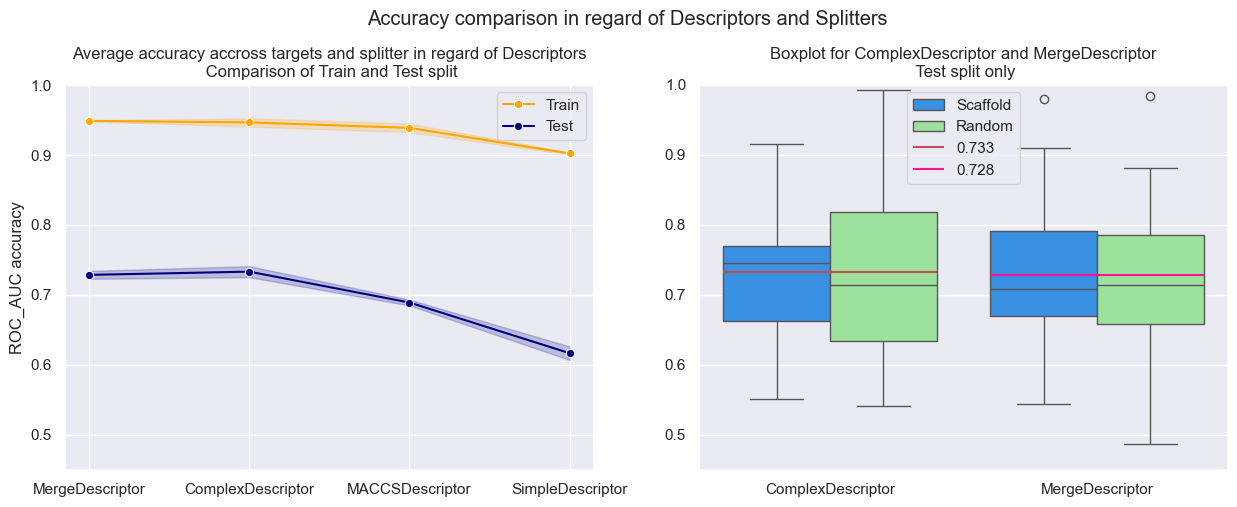

In [326]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_theme()
sns.lineplot(Accuracy_df.drop(['Target'], axis=1).groupby(['Descriptor', 'Splitter']).mean().reindex(Index_1),
             x="Descriptor", y='Train_AUC',label='Train', marker='o', ax=axes[0],color='orange')
sns.lineplot(Accuracy_df.drop(['Target'], axis=1).groupby(['Descriptor', 'Splitter']).mean().reindex(Index_1),
             x="Descriptor", y='Test_AUC', label='Test', marker='o', ax=axes[0], color='navy')


sns.boxplot(data=Accuracy_df[(Accuracy_df['Descriptor'] != 'MACCSDescriptor')&(Accuracy_df['Descriptor'] != 'SimpleDescriptor')],
            x="Descriptor", y="Test_AUC", hue="Splitter", ax=axes[1], palette=['dodgerblue', 'lightgreen'])

fig.suptitle('Accuracy comparison in regard of Descriptors and Splitters', y=1.03)

axes[0].set_title('Average accuracy accross targets and splitter in regard of Descriptors\n Comparison of Train and Test split')
axes[0].set_yticks(np.arange(0.5, 1.1, 0.1))
axes[0].set_ylim([0.45, 1])
axes[0].set_ylabel('ROC_AUC accuracy')
axes[0].set_xlabel('')

axes[1].set_title('Boxplot for ComplexDescriptor and MergeDescriptor\n Test split only')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylim([0.45, 1])
CompDesc_avg = Accuracy_df[Accuracy_df["Descriptor"] == "ComplexDescriptor"].Test_AUC.mean()
MergeDesc_avg = Accuracy_df[Accuracy_df["Descriptor"] == "MergeDescriptor"].Test_AUC.mean()
axes[1].hlines(CompDesc_avg,-0.4, 0.4, color='r', label=f'{CompDesc_avg:.3f}')
axes[1].hlines(MergeDesc_avg,0.6, 1.4, color='deeppink', label=f'{MergeDesc_avg:.3f}')

plt.legend()
fig.savefig("./Image/XGBoostAccuracyDesc")

These above plot has been created to address the question of wich descriptor set is the best one.
+ Let's focus on the left plot:
  - This figure display the average accuracy obtained across all targets for the train and test split. These line plot are grouped by splitters, which means that the line itself are an average across spliters and the thickness corresponds to the maximum average and the minimum average obtained either for Random split or Scaffold split.
  - For each target, there is an important overfitting, even though this one has been addressed as much as possible.
  - Merge Descriptor and Complex descriptor gives the best test accuracy. Let's compare them more in depth with the right plot.
+ The right plot focus on the difference between ComplexDescriptor and MergeDescriptor.
  - Each whisker plot represent how the accuracy vary across targets.
  - Merge Descriptor is proned to outliers as represented with the 2 dots for scaffold split and Random split.
  - MergeDescriptor may have targets with accuracy inferior to 0.5 which is worse than a random classifier.
  - In average, ComplexDescriptor is slightly better than MergeDescriptor as represented with the red line for ComplexDescriptor and the Pink line for the MergeDescriptor.
  - For all the precedent reason, ComplexDescriptor is thought to be a better set of descriptor than MergeDescriptor.

Let's critics however the fact that Imbalanced XGBoost has been fine tuned by using ComplexDescriptor. A choice has to be made as not every descriptor could have been tested. Therefore it may bias the result and the final decision. MergeDescriptor should not be discredited. However, let's still notice that ComplexDescriptor can reach comparable accuracy than MergeDescriptor with less features, so chosing ComplexDescriptor is also justifiable using this argument. Let's therefore keep going with ComplexDescriptor. 

### ii) Accuracy comparison across targets

In [240]:
#Computation of the Average across target for the ComplexDescriptor. 
CompDesc_avgPerTerget = Accuracy_df[Accuracy_df["Descriptor"] == "ComplexDescriptor"].iloc[:,[0,1,3]].groupby('Splitter').mean()
CompDesc_avgPerTerget

Train_AUC  Test_AUC
Splitter                     
Random     0.940428  0.740980
Scaffold   0.952194  0.725177

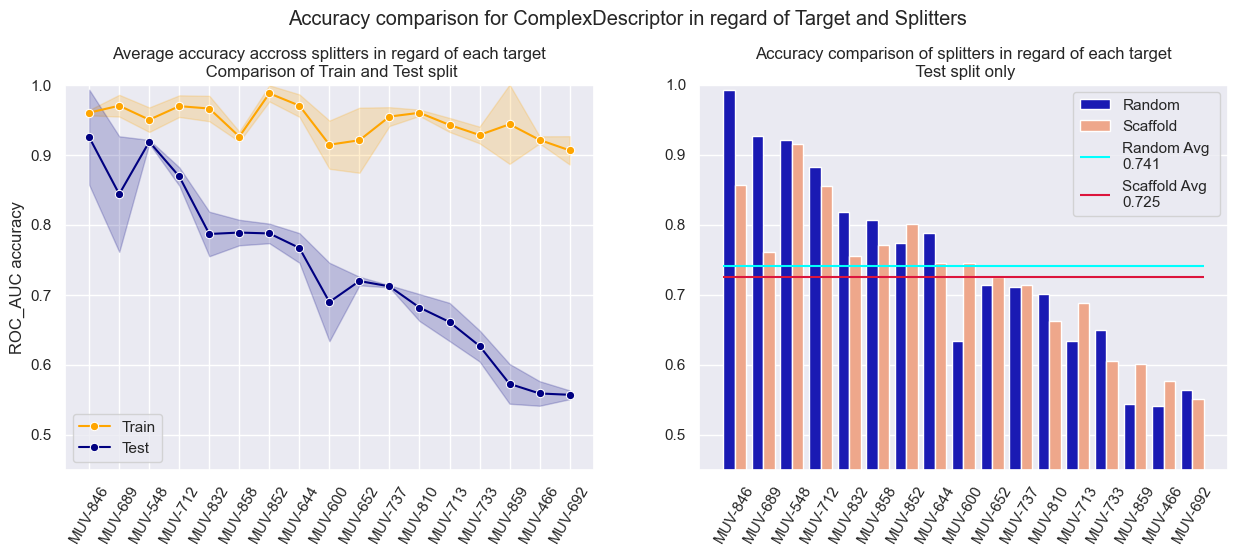

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_theme()
sns.lineplot(Accuracy_df[Accuracy_df["Descriptor"] == "ComplexDescriptor"].sort_values('Test_AUC', ascending=False),
             x="Target", y='Train_AUC',label='Train', marker='o', ax=axes[0], color='orange')
sns.lineplot(Accuracy_df[Accuracy_df["Descriptor"] == "ComplexDescriptor"].sort_values('Test_AUC', ascending=False),
             x="Target", y='Test_AUC', label='Test', marker='o', color='navy', ax=axes[0])


sns.barplot(Accuracy_df[Accuracy_df["Descriptor"] == "ComplexDescriptor"].sort_values('Test_AUC', ascending=False),
             x="Target", y='Test_AUC', hue='Splitter', palette=['mediumblue', 'lightsalmon'], ax=axes[1])

fig.suptitle('Accuracy comparison for ComplexDescriptor in regard of Target and Splitters', y=1.03)

axes[0].set_title('Average accuracy accross splitters in regard of each target\n Comparison of Train and Test split')
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_yticks(np.arange(0.5, 1.1, 0.1))
axes[0].set_ylim([0.45, 1])
axes[0].set_ylabel('ROC_AUC accuracy')
axes[0].set_xlabel('')

axes[1].set_title('Accuracy comparison of splitters in regard of each target\n Test split only')
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_ylim([0.45, 1])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].hlines(CompDesc_avgPerTerget.Test_AUC.Random,-0.4, 16.4, 
               color='cyan', label=f'Random Avg \n{CompDesc_avgPerTerget.Test_AUC.Random:.3f}')
axes[1].hlines(CompDesc_avgPerTerget.Test_AUC.Scaffold,-0.4, 16.4,
               color='crimson', label=f'Scaffold Avg \n{CompDesc_avgPerTerget.Test_AUC.Scaffold:.3f}')
axes[1].legend()
fig.savefig("./Image/XGBoostAccuracy")

These plot show an accuracy comparison across targets for the ComplexDescriptor set. 
+ Let's focus on the left plot:
  - Similar as before, this figure display the average accuracy obtained across spliters for each targets and for the train (yellow) and test (blue) split. These line plot are grouped by splitters, which means that the line itself are an average across spliters and the thickness corresponds to the maximum and the minimum obtained either for Random split or Scaffold split for a specific target.
  - This plot enlighten how much the overfitting can be very different from a target to another, or from a splitting method to another.
  - Interesting to notice that we have spot 4 targets before, in part 1)b)i): MUV-466, MUV-713, MUV-858, MUV-859 as their pca plot in the simple descriptor space was very particular. It happens that MUV-466, MUV-859, and MUV-713 are among the worse performer and suprisingly, MUV-858 is fairly good. So visualizing data initially can already be very insightful, but still, no quick conclusion should be made as shown with MUV-713.
+ Let's delve into the right plot.
  - Here this plot aim to show the accuracy difference within the two splitters for each target.
  - In 10 / 17 cases, the Random split happens to be better than scaffold split. This result is expected but as scaffold split is supposed to be more challengin than Random split, a clearer difference could have been expected. Scaffold split being much better for certain target proof the limit of the scaffold split as it might be a particularly convenient split for a specific target for some reason. 
  - Random Average is better than Scaffold split. The fact that scaffold split reaches stil a comparable accuracy shows that the Imbalance XGBoost is very robust and has a great generalisation ability.   

# 2) GNN model <a id='GraphModeling'></a>
## a) Dataset <a id='GraphDataset'></a>
### i) Loading of the Dataset 

For this portion, lecture and practice notebook on graph neural network has been used to get inspiration or get a better understanding [12]. The formation is taught in French but lecture notes or tutorial should be written in english. 

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import Chem

import torch
import torch.nn as nn
from torch.nn import BatchNorm1d, ModuleList
import torch.nn.functional as F

from torchvision.ops import sigmoid_focal_loss

from torch_geometric.transforms import ToDevice
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree, add_self_loops

#Here are some specific import for graph visualisation and does not necessarly has to be used. 
#Please feel free to comment out these three lines. 
import io
import networkx as nx
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [344]:
#Enable the use of cuda if run with a GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Let's notice that there is no need to create a graph dataset from scratch as torch geometric provide the __[MoleculeNet](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MoleculeNet.html)__ function which directly download the MUV dataset using the graph representation from OGB Database [10].

In [345]:
def load_MUV(path="./Dataset_MUV/MUV_graph"):
    '''
    Create the MUV graph dataset into the desired directory
    if not downloaded yet, else just load the dataset. 

    Parameters
    ----------
    path(string): Desired directory to download the MUV graph dataset

    Output
    ------
    MUV_graph(graph) 
    '''
    MUV_graph = MoleculeNet(path, name='MUV', transform=ToDevice(device))
    return MUV_graph

In [346]:
MUV_graph = load_MUV(path="./Dataset_MUV/MUV_graph")

### ii) Visualisation of the graph representation 

C:\Users\hugoh\AppData\Local\Temp\ipykernel_3620\804941079.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_smiles = df["smiles"][sample_num]


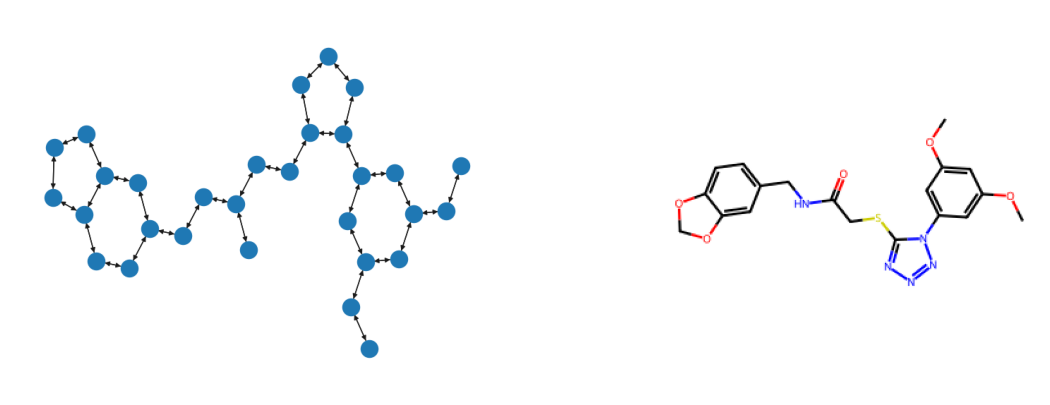

In [367]:
def compare_mol_graph(smiles, nx_graph, picture_height=5, picture_width=5):
    """ 
    Put side to side a molecule and the graph

    Parameters
    ----------
    smiles(str): the SMILES descriptor of the molecule
    nx_graph(nx.Graph): the graph in networkx format
    picture_height(float): the height of one picture
    picture_width(float): the width of one picture
    """
    # Get position of the atom in the drawing
    mol = Chem.MolFromSmiles(smiles)
    draw = Chem.Draw.MolDraw2DCairo(300, 300)
    draw.DrawMolecule(mol)
    draw.FinishDrawing()
    coords = [[draw.GetDrawCoords(i).x, draw.GetDrawCoords(i).y] for i in range(mol.GetNumAtoms())] 
    
    # Save the graph to a picture
    fig = plt.figure(figsize=(picture_width, picture_height))
    graph_io = io.BytesIO()
    nx.draw(nx_graph, pos=coords)
    fig.savefig(graph_io, format="png")
    graph_pic = Image.open(graph_io)
    plt.close()
    
    # Then put both images side to side
    fig = plt.figure(figsize=(2*picture_width, picture_height))
    fig.add_subplot(1, 2, 1)
    plt.imshow(graph_pic)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles)))
    plt.axis('off')
    
import random
from torch_geometric.utils import to_networkx
sample_num = random.randint(0, len(MUV_graph))
sample_smiles = df["smiles"][sample_num]
sample_graph = to_networkx(MUV_graph[sample_num])
compare_mol_graph(sample_smiles, sample_graph,  picture_height=5, picture_width=7)

## b) Preprocessing <a id='GraphPreprocessing'></a>

The list of descriptors is provided in the [source code](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).
For atoms (nodes in the graph):
- atomic number
- chirality. A table can be found [here](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html#a8a82ae947ebbbc48f5ec5128f5c3e724).
- degree. (number of bonded neighbors + number of Hs)
- formal electric charge
- number of hydrogen atoms connected
- number of radical electrons
- hybridization state
- part of ring
- aromaticity

And for bonds (edges in the graph):
- bond type. A table can be found [here](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Bond.html#a2c93af0aeb3297ee77b6afdc27b68d).
- stereoisomery info. A table can be found [here](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Bond.html#ae91dd8e72b495a48f46775c874882165).
- conjugation (0 or 1).

In [5]:
# Let's check the unique value taken by each of the precedent atom categorical features. 
Atom_type = ['bond type', 'chirality', 'degree', 'formal electric charge',
             'number of hydrogen atoms connected', 'number of radical electrons',
             'hybridization state', 'part of ring', 'aromaticity']
useless_feat = []
NumbFeatAfterOnehot = []
for i in range(MUV_graph.x.shape[1]):
    diff_feat = MUV_graph.x[:,i].unique().tolist()
    print(f"{Atom_type[i]}: {diff_feat}")
    if len(diff_feat) == 1:
        useless_feat.append((i,Atom_type[i]))
    else:
        NumbFeatAfterOnehot.append(len(diff_feat))
print(f"\nUseless feature(s): {useless_feat}")
print(f"Total numb of feature expected after OneHotEncoding: {np.sum(NumbFeatAfterOnehot)}")

bond type: [6, 7, 8, 9, 16, 17, 35]
chirality: [0]
degree: [1, 2, 3, 4]
formal electric charge: [4, 5, 6]
number of hydrogen atoms connected: [0, 1, 2, 3]
number of radical electrons: [0]
hybridization state: [2, 3, 4]
part of ring: [0, 1]
aromaticity: [0, 1]

Useless feature(s): [(1, 'chirality'), (5, 'number of radical electrons')]
Total numb of feature expected after OneHotEncoding: 25


In [6]:
# Let's check the unique value taken by each of the precedent atom categorical features. 
Bond_type = ['bond type', 'stereoisomery info', 'conjugation']
useless_feat = []
NumbFeatAfterOnehot = []
for i in range(MUV_graph.edge_attr.shape[1]):
    diff_feat = MUV_graph.edge_attr[:,i].unique().tolist()
    print(f"{Bond_type[i]}: {diff_feat}")
    if len(diff_feat) == 1:
        useless_feat.append(Bond_type[i])
    else:
        NumbFeatAfterOnehot.append(len(diff_feat))
print(f"\nUseless feature(s): {useless_feat if len(useless_feat) != 0 else None}")
print(f"Total numb of feature expected after OneHotEncoding: {np.sum(NumbFeatAfterOnehot)}")

bond type: [1, 2, 3, 12]
stereoisomery info: [0, 2, 3]
conjugation: [0, 1]

Useless feature(s): None
Total numb of feature expected after OneHotEncoding: 9


In [7]:
#Loading of the raw MUV dataframe (without graph) 
MUV_rawdf = pd.read_csv('./Dataset_MUV/muv.csv', sep=',', index_col='mol_id')
MUV_rawdf = MUV_rawdf[['smiles']+MUV_rawdf.columns.to_list()[:-1]]
MUV_rawdf.head()

smiles  MUV-466  \
mol_id                                                                   
CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C      NaN   
CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1      0.0   
CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...      NaN   
CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...      NaN   
CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O      0.0   

            MUV-548  MUV-600  MUV-644  MUV-652  MUV-689  MUV-692  MUV-712  \
mol_id                                                                      
CID2999678      NaN      NaN      NaN      NaN      NaN      NaN      0.0   
CID2999679      0.0      NaN      NaN      0.0      0.0      0.0      NaN   
CID2999672      NaN      0.0      NaN      NaN      NaN      NaN      NaN   
CID5390002      0.0      0.0      NaN      NaN      0.0      NaN      NaN   
CID2999670      NaN      NaN      NaN      0.0      NaN      0.0      0.0   

            MUV-713  MUV-733  MUV-737  MUV-810  MUV-832  MUV-846  MUV-852  \
mol_id                                                                      
CID2999678      NaN      NaN      NaN      0.0      NaN      NaN      NaN   
CID2999679      NaN      NaN      0.0      NaN      0.0      NaN      NaN   
CID2999672      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
CID5390002      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
CID2999670      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            MUV-858  MUV-859  
mol_id                        
CID2999678      NaN      NaN  
CID2999679      0.0      0.0  
CID2999672      NaN      0.0  
CID5390002      0.0      NaN  
CID2999670      NaN      NaN

In [8]:
#Let's split the MUV graph data set into sub set for the same reason as in part 1. 
#Impossibility to select a right value for replacing NaN values. 
Target_list = list(MUV_rawdf.iloc[:,1:].keys())
MUV_split = {k : MUV_graph[list(np.arange(MUV_rawdf.shape[0])[~MUV_rawdf[k].isna()])] for k in Target_list}
MUV_split

{'MUV-466': MUV(14841),
 'MUV-548': MUV(14734),
 'MUV-600': MUV(14728),
 'MUV-644': MUV(14623),
 'MUV-652': MUV(14902),
 'MUV-689': MUV(14601),
 'MUV-692': MUV(14644),
 'MUV-712': MUV(14411),
 'MUV-713': MUV(14836),
 'MUV-733': MUV(14682),
 'MUV-737': MUV(14691),
 'MUV-810': MUV(14644),
 'MUV-832': MUV(14667),
 'MUV-846': MUV(14711),
 'MUV-852': MUV(14651),
 'MUV-858': MUV(14774),
 'MUV-859': MUV(14746)}

In [9]:
Atom_FeatKept = [0, 2, 3, 4, 6, 7, 8]
TargetNumb = {k: i for i,k in enumerate(list(MUV_split.keys()))}


class GraphProcessing():
    '''
    Define processing method which OneHotEncode the atom features and bond features 
    while removing the useless features.
    And transform the y matrices with the 17 target into the vector of 
    interest with the specific target. 

    Parameters
    ----------
    Atom_FeatKept(list(int)): must be the Atome features to keep identify in the precedent part
    graph(graph): Should be the MUV_graph or subset of it generated with GraphDataLoader
    target(int): Must be the int associated to the specific target to select. This int it the order
         in which the target are initially sorted. The best practice is to use the dict TargetNumb
    '''
    def __init__(self, Atom_FeatKept, graph=MUV_graph, target=TargetNumb[Target_list[0]]):
        self.KeptFeat = Atom_FeatKept
        self.AtomOneHot = OneHotEncoder().fit(graph.x[:,Atom_FeatKept].cpu())
        self.EdgeOneHot = OneHotEncoder().fit(graph.edge_attr.cpu())
        self.target = target
    def transform(self, data):
        data.x = torch.Tensor(self.AtomOneHot.transform(data.x[:,self.KeptFeat].cpu()).toarray())
        data.x = data.x.to(device)
        data.edge_attr = torch.Tensor(self.EdgeOneHot.transform(data.edge_attr.cpu()).toarray())
        data.edge_attr = data.edge_attr.to(device)
        data.y = data.y[:,self.target]

## c) Splitting method <a id='GraphSplit'></a>
For convenience purposes, the splitting techniques are exactly the same as in part 1. 
### i) Function definition

In [10]:
MUV_dict = {k : {"Classification": MUV_rawdf[["smiles", k]][~MUV_rawdf[k].isna()]} for k in list(MUV_rawdf.keys())[1::]}
def RandomSplit(target, dict, frac_train, iteration):
    '''
    Output the training index and the test index for the random splitting method

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).
    frac_train(float): training fraction. 0 < frac_train < 1
    iteration(int): the number of iteration of random split oto be tested to get a more a robust prediction
        of the model accuracy. 

    Output
    ------
    train_index_list(list(ndarrat): training index in regard of a specific target
    val_index_list(ndarray): valid index in regard of a specific target
    '''
    neg_index = np.arange(dict[target]["Classification"].shape[0])[(dict[target]["Classification"].iloc[:,1]==0)]
    pos_index = np.arange(dict[target]["Classification"].shape[0])[(dict[target]["Classification"].iloc[:,1]==1)]
    train_index_list, val_index_list = [], []
    for _ in range(iteration):
        train_index_0, val_index_0 = train_test_split(neg_index,train_size=frac_train, shuffle=True)
        train_index_1, val_index_1 = train_test_split(pos_index,train_size=frac_train, shuffle=True)
        train_index = np.concatenate((train_index_0, train_index_1))
        np.random.shuffle(train_index)
        train_index_list.append(torch.Tensor(train_index).long())
        val_index = np.concatenate((val_index_0, val_index_1))
        np.random.shuffle(val_index)
        val_index_list.append(torch.Tensor(val_index).long())
    return train_index_list, val_index_list


def Generate_Scaffold(target, dict=MUV_dict):
    '''
    Create the scaffold sets

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).

    Output
    ------
    scaffold_sets(dicct): this is sorted dict, where in first order are the scaffold with the most occurence
    within the MUV dataset. 
    '''
    scaffolds= {}
    for id, sm in enumerate(dict[target]["Classification"]["smiles"].values):
        scaffold = MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(sm), includeChirality=False)
        if scaffold is not None:
            if scaffold not in scaffolds:
                scaffolds[scaffold] = [id]
            else:
                scaffolds[scaffold].append(id)
                
        # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set
        for (scaffold,
             scaffold_set) in sorted(scaffolds.items(),
                                     key=lambda x: (len(x[1]), x[1][0]),
                                     reverse=True)
    ]
    return scaffold_sets

def Scaffold_Splitter(target, dict=MUV_dict, frac_train=0.8):
    '''
    Output the training index and the test index for the scaffold splitting method

    Parameters
    ----------
    target(string): must be part of Target_list. typically MUV-466 and so on. 
    dict(dict): must be the MUV_dict defined above (the splitted MUV dataframe into a dict).
    frac_train(float): training fraction. 0 < frac_train < 1

    Output
    ------
    train_inds(ndarray): training index in regard of a specific target
    valid_inds(ndarray): valid index in regard of a specific target
    '''
    scaffold_sets = Generate_Scaffold(target, MUV_dict)
    
    if not (0 < frac_train < 1):
        raise print(f"frac_train must be within 0 and 1 excluded. Here {frac_train} was provided")
        
    frac_val = 1 - frac_train
    numb_mol = len(dict[target]["Classification"])
    train_cutoff = frac_train * numb_mol
    train_inds = []
    valid_inds = []

    for scaffold_set in scaffold_sets:
        if len(train_inds) + len(scaffold_set) > train_cutoff:
            valid_inds += scaffold_set
        else:
            train_inds += scaffold_set
    train_inds = torch.Tensor(train_inds).long()
    valid_inds = torch.Tensor(valid_inds).long()
    return train_inds, valid_inds

### ii) Some trials of the function coded

In [11]:
train_inds, valid_inds = Scaffold_Splitter(Target_list[0], MUV_dict, frac_train=0.8)
print(train_inds)
print(valid_inds)

tensor([   1,  222,  231,  ..., 6235, 6232, 6231])
tensor([6229, 6226, 6225,  ...,    4,    3,    0])


In [12]:
dataloader = GraphDataLoader(MUV_split[Target_list[0]][train_inds], batch_size=2, shuffle=False)
MUV_processing = GraphProcessing(Atom_FeatKept, MUV_graph, TargetNumb[Target_list[0]])
for data in dataloader:
    MUV_processing.transform(data)
    print(data)
    print("Is graph in CUDA?", 
          (data.x.get_device()==0)&(data.edge_attr.get_device()==0)&(data.edge_index.get_device()==0))
    break

DataBatch(x=[32, 25], edge_index=[2, 64], edge_attr=[64, 9], smiles=[2], y=[2], batch=[32], ptr=[3])
Is graph in CUDA? True


In [13]:
train_index_list, val_index_list = RandomSplit(Target_list[0], MUV_dict, frac_train=0.8, iteration=2)
print(train_index_list[0])
print(val_index_list[0])

tensor([ 5213,  1427,  1150,  ..., 13151,  8604,  4367])
tensor([ 5423,  5134,  6347,  ...,   214,  4490, 11897])


In [14]:
dataloader = GraphDataLoader(MUV_split[Target_list[0]][train_index_list[0]], batch_size=2, shuffle=False)
MUV_processing = GraphProcessing(Atom_FeatKept, MUV_graph, TargetNumb[Target_list[0]])
for data in dataloader:
    MUV_processing.transform(data)
    print(data)
    break

DataBatch(x=[56, 25], edge_index=[2, 120], edge_attr=[120, 9], smiles=[2], y=[2], batch=[56], ptr=[3])


## d) Model <a id='GraphModel'></a> 

Let's build a graph neural network. Here is a self made picture of the intended graph neural network that will be build. For illustration purposes there is 4 Message Passing Neural Network, but more or less can be used.  

<h3><center> GNN Architecture </center></h3>

![GNNArchitecture](./Image/GNN_architecture.png)

Here as follow is a self made picture of the Message passing neural network (or the GCNConv class)

<h3><center> MPNN Architecture </center></h3>

![MPNNArchitecture](./Image/MPNN_architechture.png)

Usually, in [10] and [11] node and bonds are embedded using Embedding layer. Here an alternative solution has been tested to OneHotEncode and then use Linear Layer for the embedding. This decision may result in accuracy difference in comparison to the litterature in addition to the architecture difference. 

In [15]:
class GCNConv(MessagePassing):
    """
        MessagePassing doc: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html
    """
    def __init__(self, edge_dim, emb_dim, aggr="add"):
        """ 
        Initialize the convolutional layer

        Parameters
        -----------
        edge_dim(int): input dim of edge. After the oneHotEncode, it should be 9 in our case.
        emb_dim(int): dimension of the latent space
        aggr(string): aggregation strategy (default: add)
        """
        super(GCNConv,self).__init__(aggr=aggr)
        self.aggr = aggr
        self.emb_dim = emb_dim
        # Output fully connected layer https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear = nn.Linear(emb_dim, emb_dim)
        # Embedding layer https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.root_emb = nn.Embedding(1, emb_dim)
        # Encoder for bonds
        self.bond_encoder = nn.Linear(edge_dim, emb_dim, bias=False)
    
    def forward(self, x, edge_index, edge_attr):
        #refers to the documentation on Message passing neural network. 
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)
        
        row, col = edge_index
        
        deg = degree(row, x.size(0), dtype=x.dtype) + 1
        deg_inv_sqrt = deg.pow(0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight)*1.0/deg.view(-1,1)
    
    def message(self, x_j, edge_attr, norm):
        # Flatten the norm tensor
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)
    
    def update(self, aggr_out):
        return aggr_out
                              
class GNN(torch.nn.Module):
    ''' Define the GNN '''
    def __init__(self, node_dim, edge_dim, num_tasks=1, 
                 num_layers=4, 
                 emb_dim=100,
                 drop_ratio=0.1):
        '''
        Initialize GNN

        Parameters
        -----------
        node_dim(int): input node dimension (here 25)
        edge_dim(int): input edge dimension (here 9)
        num_tasks(int): number of tasks fort the classification
            here as it is one sequentially, it should be 1. 
        num_layers(int): number of GNN convolution layers
        emb_dim(int): dimension of the latent space
        drop_ratio(float): dropout ratio between 0 and 1
        '''
        super(GNN,self).__init__()
        self.num_tasks = num_tasks
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        self.drop_ratio = drop_ratio
        
        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        self.atom_encoder = nn.Linear(node_dim, emb_dim, bias=False)
        
        for _ in range(self.num_layers):
            self.convs.append(GCNConv(edge_dim, self.emb_dim))
            self.batch_norms.append(BatchNorm1d(self.emb_dim))
        
        # Define pooling
        self.pool = global_max_pool
        
        # Define the linear layer
        self.prediction_linear_layer = nn.Linear(emb_dim, num_tasks)
    
    def forward(self, batch_data):
        x = batch_data.x
        edge_index = batch_data.edge_index
        edge_attr = batch_data.edge_attr
        batch = batch_data.batch
        h = self.atom_encoder(x)
        for layer in range(self.num_layers-1):
            h = self.convs[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            h = F.relu(h)
            h = F.dropout(h, self.drop_ratio, training = self.training)
        # Do not apply ReLU on last layer
        h = self.convs[-1](h, edge_index, edge_attr)
        h = self.batch_norms[-1](h)
        h = F.dropout(h, self.drop_ratio, training=self.training)
        # We use Jk-concat (Jumping knowledge) "last" strategy so we keep only the last node representation
        #    We could have used a list of the representations and summed them up
        # We also choose not to used residual connections h[i] += h[i-1] 
        
        h_graph = self.pool(h, batch_data.batch)
        return self.prediction_linear_layer(h_graph)

## e) Trainer <a id='GraphTrainer'></a>

Based on the learning of the first part, the Focal loss is used. In pytorch, this focal loss can be weighted with a parameter alpha, to further address unbalance, but after some testing, the best results were obtained with alpha not considered. 

In [16]:
class GNNTrainer:
    '''
    Model trainer
    '''
    def __init__(self, model, batch_size, learning_rate, epoch, l2, processing_tool, alpha, gamma):

        '''
        Initialization 

        Parameters
        ----------
        model(Pytorch model): model to be trained
        batch_size(int): size of the batch to use for GraphDataLoader
        learning_rate(float): learning rate for the optimiser Adam
        epoch(int): The number of training roung to achieve
        l2(float): regularization of the loss to reduce overfitting
        processing_tool(GraphProcessing): must be a graphprocessing object 
            defined with the desired target. 
        alpha(float): the weight to use for the weighted focal loss. 
            if alpha=-1, the weight is not considered. 
        gamma(float): the gamma to use for the focal loss. 
        '''
        self.model = model

        num_params = sum(item.numel() for item in model.parameters())
        #print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.processing_tool = processing_tool
        self.gamma = gamma
        self.alpha = alpha

    def train(self, train_dataset, test_dataset, draw_curve=True, early_stop=True):
        self.model.train()
        loader = GraphDataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        batch_loss_list = []
        train_acc_all = []
        test_acc_all = []
        train_acc_max = 0
        test_acc_kept = 0
        for i in tqdm(range(self.epoch), leave=True):
            #print(f"Epoch: {i}")
            y_true, y_pred = [], []
            for batch_data in loader:
                self.processing_tool.transform(batch_data)
                batch_size = batch_data.y.shape[0]
                batch_pred = self.model(batch_data)
                #alpha = torch.sum(batch_data.y==1)/torch.sum(batch_data.y==0)
                batch_loss = sigmoid_focal_loss(torch.flatten(batch_pred), batch_data.y.to(device), 
                                                alpha=self.alpha, gamma=self.gamma, reduction="sum")

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.detach().cpu().numpy())
                y_pred.append(batch_pred.detach().cpu().numpy().flatten())
                y_true.append(batch_data.y.detach().cpu().numpy().flatten())
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            train_acc_all.append(roc_auc_score(y_true, y_pred))
            test_acc_all.append(self.evaluate(test_dataset))
            if early_stop:
                if train_acc_all[-1] > train_acc_max:
                    train_acc_max = train_acc_all[-1]
                    test_acc_kept = test_acc_all[-1]
                    weights = self.model.state_dict()
        if early_stop:
            self.model.load_state_dict(weights)
            
        if draw_curve:
            fig, ax = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
            ax[0].set_yscale("log")
            ax[0].plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax[0].set_xlabel("# Batch")
            ax[0].set_ylabel("Loss")

            ax[1].plot(np.arange(len(train_acc_all)), train_acc_all, label='train')
            ax[1].plot(np.arange(len(test_acc_all)), test_acc_all, label='test')
            ax[1].set_xlabel("# Epoch")
            ax[1].set_ylabel("ROC_AUC")
            ax[1].legend()
            return batch_loss_list, train_acc_all, test_acc_all, self.model
        else:
            return batch_loss_list, train_acc_max, test_acc_kept, self.model

    def evaluate(self, dataset): #draw_curve=True):
        self.model.eval()
        loader = GraphDataLoader(dataset, batch_size=self.batch_size)
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in loader:
                self.processing_tool.transform(batch_data)
                batch_pred = self.model(batch_data.to(device))
                y_pred.append(batch_pred.detach().cpu().numpy().flatten())
                y_true.append(batch_data.y.detach().cpu().numpy().flatten())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        Accuracy = roc_auc_score(y_true, y_pred)
        #print(f"Test accuracy: {Accuracy}")
        return Accuracy

Here as a training take 3 min even with a GPU, the fine tunning is therefore complicated to achieve. As MUV-466 is known to be challenging thanks to the XGBoost model, it will be the target that will be used to fine tune the model. Also Random split has been used.
For concision purposes, let's summarize some trials tested into the following table

| drop_ratio  |             alpha               | learning_rate | batch_size | epoch | Accuracy |
| ----------- | ------------------------------- | ------------- | ---------- | ----- | -------- |
|    0.1      |  $\frac{sum(y==1)}{sum(y==0)}$  |     1e-3      |    128     |  30   |   ~0.5   |
|    0.1      |              -1                 |     1e-3      |    128     |  30   |   ~0.75  |
|    0.1      |              -1                 |     5e-4      |    128     |  30   |   ~0.77  |
|    0.1      |              -1                 |     5e-4      |    256     |  30   |   ~0.65  |
|    0.4      |              -1                 |     5e-4      |    256     |  30   |   ~0.65  |
|    0.4      |              -1                 |     5e-4      |    128     |  30   |   ~0.60  |
|    0.1      |              -1                 |     5e-4      |    128     |  40   |   ~0.70  |

The above result may be very dependent on the Random split or just on the randomness of the optimisation. Only a single test was perform due to the 3 min duration. 

For illustration purposes, a single training has been let. The others has been removed and only the optimal set (the 3rd line of the table) has been used to be tested on the whole set of Targets, one time on scaffold split and 3 times on Random split (for more robustnesss), with a total time of training of ~3h30 with a GPU. 

In [17]:
node_dim = 25
edge_dim = 9
alpha = torch.mean(torch.Tensor([torch.sum(MUV_graph.y[:,i]==1)/torch.sum(MUV_graph.y[:,i]==0) 
                         for i in range(MUV_graph.y.shape[1])]))
target = Target_list[0]
Atom_FeatKept = [0, 2, 3, 4, 6, 7, 8]

train_index_list, val_index_list = RandomSplit(target, MUV_dict, frac_train=0.8, iteration=1)
processing_tool = GraphProcessing(Atom_FeatKept, MUV_graph, TargetNumb[target])

GNN - Number of parameters: 47801


100%|██████████| 30/30 [02:44<00:00,  5.50s/it]


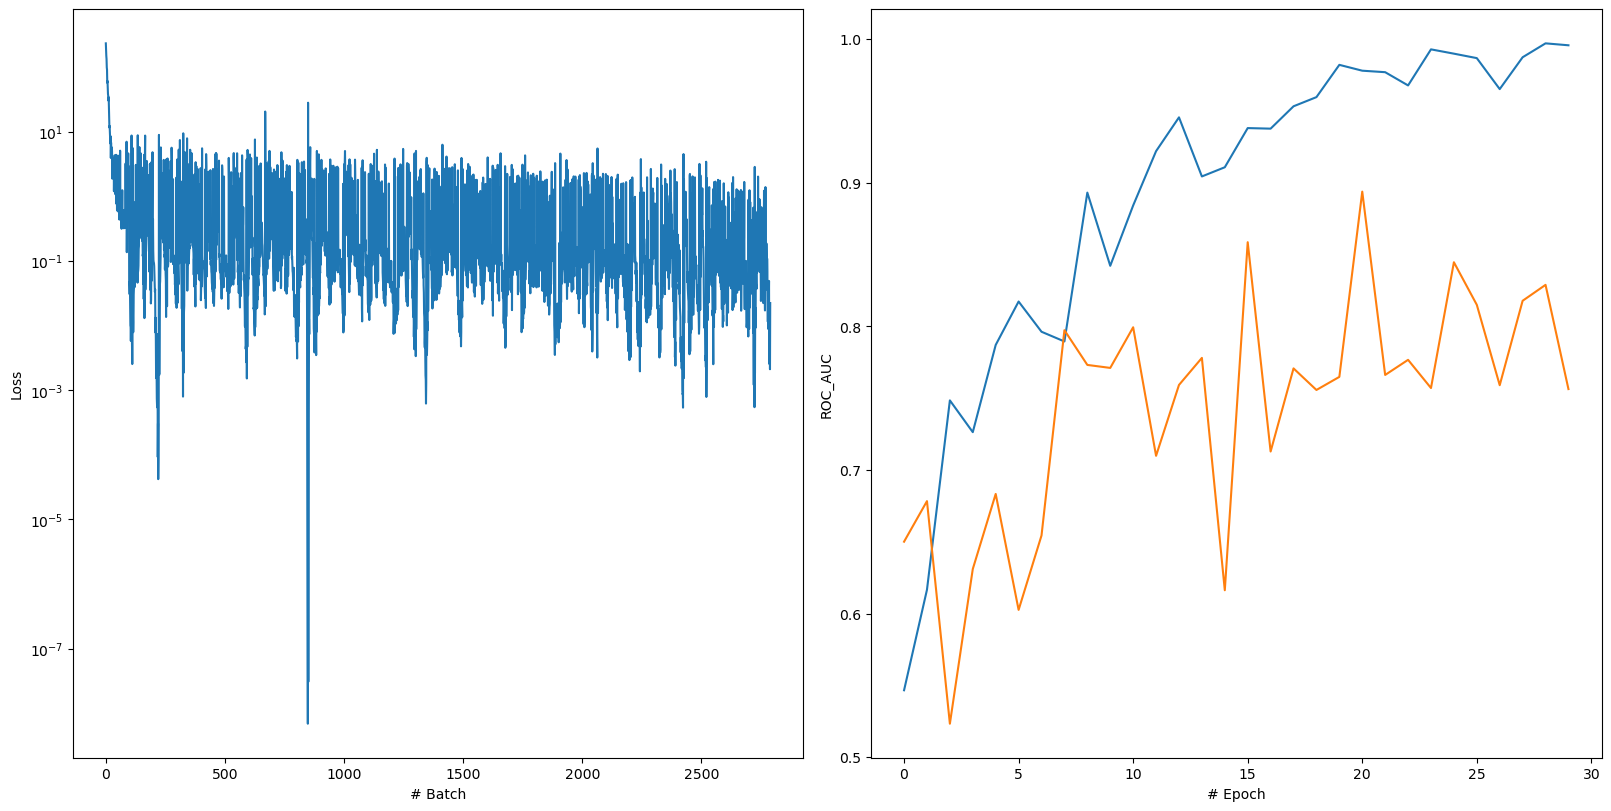

In [191]:
model = GNN(node_dim, edge_dim, num_tasks=1, 
                 num_layers=4, 
                 emb_dim=100,
                 drop_ratio=0.1)
model.to(device)
Trainer = GNNTrainer(model, batch_size=128, 
                     learning_rate=0.0005, 
                     epoch=30, l2=1e-5, 
                     processing_tool=processing_tool, alpha=-1, gamma=1.4)

batch_loss_list, train_acc_all, test_acc_all, trained_model = Trainer.train(MUV_split[target][train_index_list[0]], 
                                                              MUV_split[target][val_index_list[0]],
                                                              draw_curve=True)

In [ ]:
#Due to tqdm, this cell give a very long output which has been cleared as it is just loading bars. 
node_dim = 25
edge_dim = 9
Atom_FeatKept = [0, 2, 3, 4, 6, 7, 8]
Accuracy_dict = {"Train_AUC": [], "Test_AUC": [], "Target": [], "Splitter": []}
iteration = 3
for target in tqdm(Target_list, leave=True): 
    processing_tool = GraphProcessing(Atom_FeatKept, MUV_graph, TargetNumb[target])
    for splitter in tqdm(["Scaffold", "Random"], leave=True):
        if splitter == "Scaffold":
            train_inds, test_inds = Scaffold_Splitter(target, MUV_dict, frac_train=0.8)
            train_index_list, test_index_list = [train_inds], [test_inds]
        else:
            train_index_list, test_index_list = RandomSplit(target, MUV_dict, frac_train=0.8, iteration=iteration)
        
        best_train_list, best_test_list = [], []
        for train_idx, test_idx in zip(train_index_list, test_index_list):
            model = GNN(node_dim, edge_dim, num_tasks=1, 
                         num_layers=4, 
                         emb_dim=100,
                         drop_ratio=0.1)
            model.to(device)
            Trainer = GNNTrainer(model, batch_size=128, 
                                 learning_rate=0.0005, 
                                 epoch=30, l2=1e-5, 
                                 processing_tool=processing_tool, alpha=-1, gamma=1.4)  
            _, best_train, best_test, _ = Trainer.train(MUV_split[target][train_idx], 
                                                                  MUV_split[target][test_idx],
                                                                  draw_curve=False, early_stop=True)
            best_train_list.append(best_train)
            best_test_list.append(best_test)
        

        Accuracy_dict["Train_AUC"].append(np.mean(best_train_list))
        Accuracy_dict["Test_AUC"].append(np.mean(best_test_list))
        Accuracy_dict["Target"].append(target)
        Accuracy_dict["Splitter"].append(splitter)

## f) Result <a id='GraphResult'></a> 

In [7]:
if os.path.exists("./Dataset_MUV/GNN_Accuracy.csv"):
    Accuracy_df_GNN = pd.read_csv("./Dataset_MUV/GNN_Accuracy.csv", )
    Accuracy_df_GNN = Accuracy_df_GNN.iloc[:,1:]
else:
    Accuracy_df_GNN = pd.DataFrame(Accuracy_dict)
    Accuracy_df_GNN.to_csv("./Dataset_MUV/GNN_Accuracy.csv")

In [8]:
Accuracy_df_GNN

Train_AUC  Test_AUC   Target  Splitter
0    0.994612  0.525174  MUV-466  Scaffold
1    0.988992  0.693385  MUV-466    Random
2    0.991193  0.895500  MUV-548  Scaffold
3    0.997691  0.811780  MUV-548    Random
4    0.948454  0.649718  MUV-600  Scaffold
5    0.962287  0.796920  MUV-600    Random
6    0.998256  0.851507  MUV-644  Scaffold
7    0.994860  0.876308  MUV-644    Random
8    0.999337  0.591827  MUV-652  Scaffold
9    0.990863  0.763754  MUV-652    Random
10   0.998045  0.696985  MUV-689  Scaffold
11   0.995327  0.645378  MUV-689    Random
12   0.966523  0.679724  MUV-692  Scaffold
13   0.986274  0.645684  MUV-692    Random
14   0.998655  0.686569  MUV-712  Scaffold
15   0.998623  0.830437  MUV-712    Random
16   0.985659  0.526896  MUV-713  Scaffold
17   0.987409  0.631424  MUV-713    Random
18   0.988959  0.602637  MUV-733  Scaffold
19   0.993721  0.741082  MUV-733    Random
20   0.971356  0.781532  MUV-737  Scaffold
21   0.982494  0.759386  MUV-737    Random
22   0.979743  0.670236  MUV-810  Scaffold
23   0.995722  0.698540  MUV-810    Random
24   0.999987  0.616968  MUV-832  Scaffold
25   0.999120  0.893120  MUV-832    Random
26   0.998783  0.984529  MUV-846  Scaffold
27   0.995906  0.934552  MUV-846    Random
28   0.999836  0.702939  MUV-852  Scaffold
29   0.999492  0.933827  MUV-852    Random
30   0.996083  0.757540  MUV-858  Scaffold
31   0.991045  0.679100  MUV-858    Random
32   0.972662  0.522347  MUV-859  Scaffold
33   0.992939  0.469383  MUV-859    Random

In [9]:
AvgperTarget = Accuracy_df_GNN.iloc[:,[0,1,3]].groupby('Splitter').mean()
AvgperTarget

Train_AUC  Test_AUC
Splitter                     
Random     0.991339  0.753180
Scaffold   0.987538  0.690743

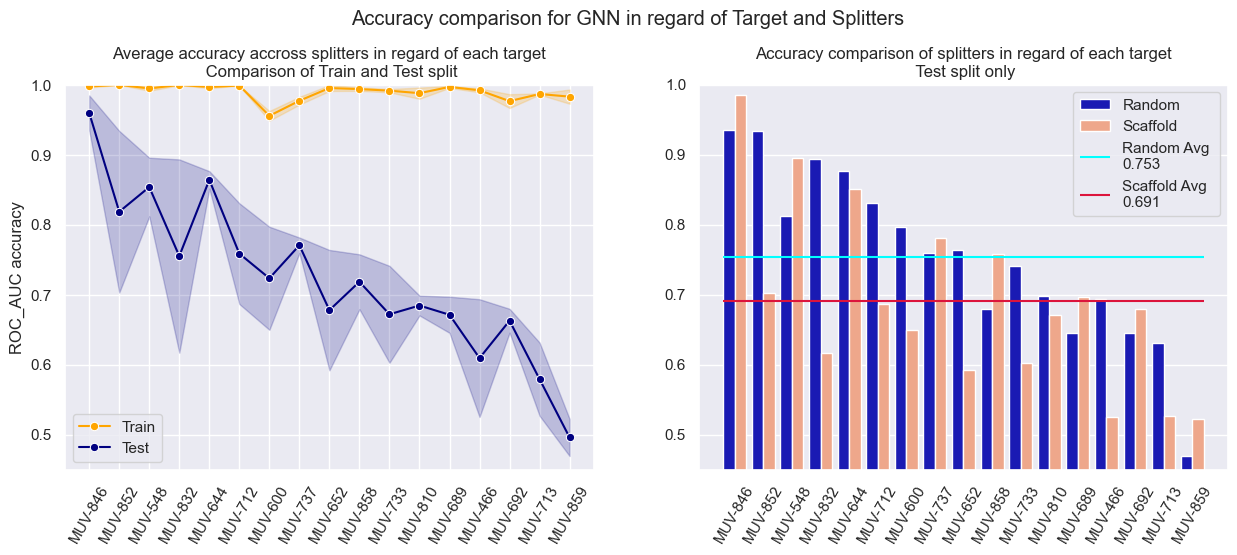

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_theme()
sns.lineplot(Accuracy_df_GNN.sort_values('Test_AUC', ascending=False),
             x="Target", y='Train_AUC',label='Train', marker='o', ax=axes[0], color='orange')
sns.lineplot(Accuracy_df_GNN.sort_values('Test_AUC', ascending=False),
             x="Target", y='Test_AUC', label='Test', marker='o', color='navy', ax=axes[0])


sns.barplot(Accuracy_df_GNN.sort_values('Test_AUC', ascending=False),
             x="Target", y='Test_AUC', hue='Splitter', hue_order=["Random","Scaffold"], palette=['mediumblue', 'lightsalmon'], ax=axes[1])

fig.suptitle('Accuracy comparison for GNN in regard of Target and Splitters', y=1.03)

axes[0].set_title('Average accuracy accross splitters in regard of each target\n Comparison of Train and Test split')
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_yticks(np.arange(0.5, 1.1, 0.1))
axes[0].set_ylim([0.45, 1])
axes[0].set_ylabel('ROC_AUC accuracy')
axes[0].set_xlabel('')

axes[1].set_title('Accuracy comparison of splitters in regard of each target\n Test split only')
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_ylim([0.45, 1])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].hlines(AvgperTarget.Test_AUC.Random,-0.4, 16.4, 
               color='cyan', label=f'Random Avg \n{AvgperTarget.Test_AUC.Random:.3f}')
axes[1].hlines(AvgperTarget.Test_AUC.Scaffold,-0.4, 16.4,
               color='crimson', label=f'Scaffold Avg \n{AvgperTarget.Test_AUC.Scaffold:.3f}')
axes[1].legend()
#fig.savefig("./Image/GNNAccuracyTarg")

These plot show an accuracy comparison across targets for the GNN model. 
+ Let's focus on the left plot:
  - This figure display the average accuracy obtained across spliters for each targets and for the train (yellow) and test (blue) split. These line plot are grouped by splitters, which means that the line itself are an average across spliters and the thickness corresponds to the maximum and the minimum obtained either for Random split or Scaffold split for a specific target.
  - This plot enlighten how much the overfitting can be very different from a target to another, or from a splitting method to another.
  - The same observation done in part 1)e)ii) can be made for the GNN model as well. 4 targets has been spotted in part 1)b)i): MUV-466, MUV-713, MUV-858, MUV-859 as their pca plot in the simple descriptor space was very particular. It happens that MUV-466, MUV-859, and MUV-713 are among the worse performer and suprisingly, MUV-858 is fairly good (as for the ImbXGboost model). So visualizing data initially can already be very insightful, but still, no quick conclusion should be made as shown with MUV-713.
+ Let's delve into the right plot.
  - Here this plot aims to show the accuracy difference within the two splitters for each target.
  - Here, in 11 / 17 cases, the Random split happens to be better than scaffold split (compared to 10/17 with the ImbXGBoost model). This result is expected as scaffold split is supposed to be more challenging than Random split. Here a clearer difference between the Scaffold split and the Random split is observed as the average obtained is respectively 0.753 vs 0.691. Scaffold split being much better for certain target proof the limit of the scaffold split as it might be a particularly convenient split for specific target for some reason. 
  - The more important difference in Random split performance compared to Scaffold split shows that the GNN looks to have a worse ability to generalize than ImbXGBoost.  

# 3) Conclusion <a id='Conclusion'></a>
## a) Comparison of the 2 modeling <a id='ConcComparison'></a>

Let's now conclude on the performance of both modeling

In [15]:
if os.path.exists("./Dataset_MUV/ImbXGBoost_Accuracy.csv"):
    Accuracy_df = pd.read_csv("./Dataset_MUV/ImbXGBoost_Accuracy.csv", )
    Accuracy_df = Accuracy_df.iloc[:,1:]

XGBoostAcc = Accuracy_df[Accuracy_df["Descriptor"]=="ComplexDescriptor"].iloc[:,:-1]
XGBoostAcc.insert(4, "Model", ["XGBoost" for _ in range(XGBoostAcc.shape[0])],True)
Accuracy_df_GNN.insert(4, "Model", ["GNN" for _ in range(Accuracy_df_GNN.shape[0])], True)
MergedAcc = pd.concat([XGBoostAcc, Accuracy_df_GNN])

In [16]:
MergedAcc

Train_AUC  Test_AUC   Target  Splitter    Model
34   0.926109  0.576309  MUV-466  Scaffold  XGBoost
35   0.932311  0.915703  MUV-548  Scaffold  XGBoost
36   0.948563  0.745432  MUV-600  Scaffold  XGBoost
37   0.986002  0.745479  MUV-644  Scaffold  XGBoost
38   0.874007  0.725436  MUV-652  Scaffold  XGBoost
..        ...       ...      ...       ...      ...
29   0.999492  0.933827  MUV-852    Random      GNN
30   0.996083  0.757540  MUV-858  Scaffold      GNN
31   0.991045  0.679100  MUV-858    Random      GNN
32   0.972662  0.522347  MUV-859  Scaffold      GNN
33   0.992939  0.469383  MUV-859    Random      GNN

[68 rows x 5 columns]

In [23]:
print(MergedAcc[MergedAcc["Model"]=="XGBoost"][MergedAcc["Splitter"]=="Random"].iloc[:,1].std())
print(MergedAcc[MergedAcc["Model"]=="GNN"][MergedAcc["Splitter"]=="Random"].iloc[:,1].std())

0.1388872983272818
0.1231045947861873


In [17]:
MergeAcc_avg = MergedAcc.iloc[:,[1,3,4]].groupby(["Model", "Splitter"]).mean()
MergeAcc_avg.loc["GNN"].loc["Random"].values

array([0.75317996])

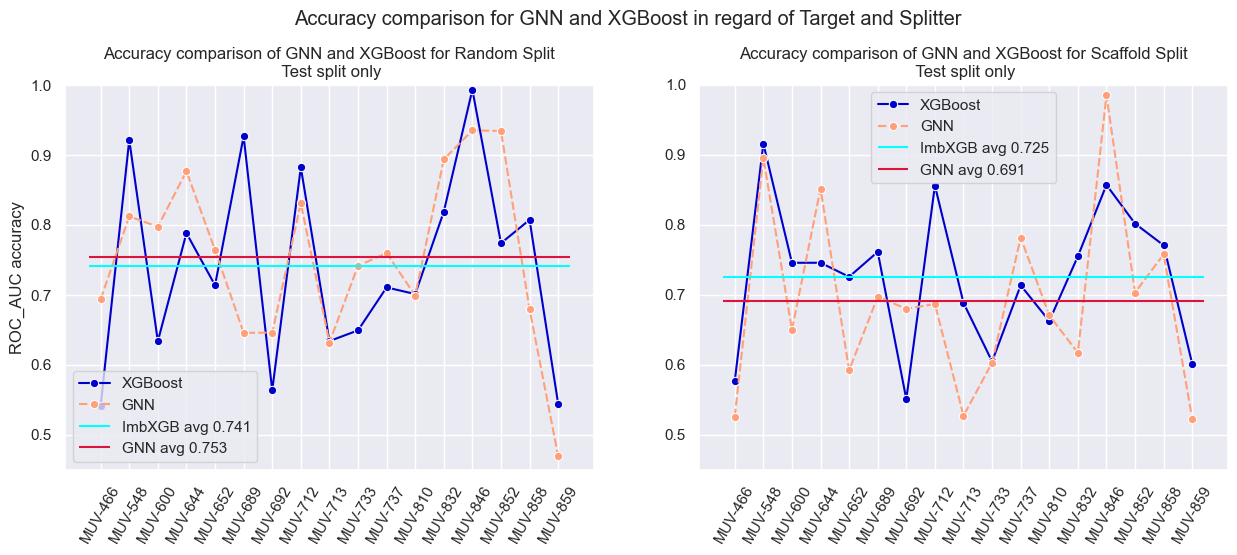

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.set_theme()
sns.lineplot(MergedAcc[MergedAcc["Splitter"]=="Random"],
             x="Target", y='Test_AUC', hue='Model', style='Model', hue_order=["XGBoost","GNN"], markers=["o","o"],
             palette=['mediumblue', 'lightsalmon'], ax=axes[0])

sns.lineplot(MergedAcc[MergedAcc["Splitter"]=="Scaffold"],
             x="Target", y='Test_AUC', hue='Model', style='Model', hue_order=["XGBoost","GNN"], markers=["o","o"],
             palette=['mediumblue', 'lightsalmon'], ax=axes[1])

fig.suptitle('Accuracy comparison for GNN and XGBoost in regard of Target and Splitter', y=1.03)

axes[0].set_title('Accuracy comparison of GNN and XGBoost for Random Split\n Test split only')
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_yticks(np.arange(0.5, 1.1, 0.1))
axes[0].set_ylim([0.45, 1])
axes[0].set_ylabel('ROC_AUC accuracy')
axes[0].set_xlabel('')
axes[0].hlines(MergeAcc_avg.loc["XGBoost"].loc["Random"].values,-0.4, 16.4, 
               color='cyan', label=f'ImbXGB avg {float(MergeAcc_avg.loc["XGBoost"].loc["Random"].values):.3f}')
axes[0].hlines(MergeAcc_avg.loc["GNN"].loc["Random"],-0.4, 16.4,
               color='crimson', label=f'GNN avg {float(MergeAcc_avg.loc["GNN"].loc["Random"]):.3f}')
axes[0].legend()

axes[1].set_title('Accuracy comparison of GNN and XGBoost for Scaffold Split\n Test split only')
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_ylim([0.45, 1])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].hlines(MergeAcc_avg.loc["XGBoost"].loc["Scaffold"],-0.4, 16.4, 
               color='cyan', label=f'ImbXGB avg {float(MergeAcc_avg.loc["XGBoost"].loc["Scaffold"].values):.3f}')
axes[1].hlines(MergeAcc_avg.loc["GNN"].loc["Scaffold"],-0.4, 16.4,
               color='crimson', label=f'GNN avg {float(MergeAcc_avg.loc["GNN"].loc["Scaffold"].values):.3f}')
axes[1].legend()
#fig.savefig("./Image/GNNvsXGBoostAccuracyTarg")

In [31]:
print(f'XGBoost std for random split: {MergedAcc[MergedAcc["Model"]=="XGBoost"][MergedAcc["Splitter"]=="Random"].iloc[:,1].std():0.3f}')
print(f'GNN std for random split: {MergedAcc[MergedAcc["Model"]=="GNN"][MergedAcc["Splitter"]=="Random"].iloc[:,1].std():0.3f}')
print(f'XGBoost std for random split: {MergedAcc[MergedAcc["Model"]=="XGBoost"][MergedAcc["Splitter"]=="Scaffold"].iloc[:,1].std():0.3f}')
print(f'GNN std for random split: {MergedAcc[MergedAcc["Model"]=="GNN"][MergedAcc["Splitter"]=="Scaffold"].iloc[:,1].std():0.3f}')

XGBoost std for random split: 0.139
GNN std for random split: 0.123
XGBoost std for random split: 0.103
GNN std for random split: 0.131


These plot show an accuracy comparison across targets for the GNN and the ImbXGBoost model.
+ Let's delve into the left plot which compares the accuracy for the Random Split. 
  - The GNN accuracy accross targets looks a little bit smoother. This intuition can be checked looking at the standard deviation of accuracy obtained.
    The standard deviation of the GNN model is indeed smaller which is interesting in term of consistency of prediction across targets.
  - The average accuracy obtained for the GNN model is slightly better compared to ImbXGBoost: 0.753 vs 0.741.
  - Let's note however that GNN will suprinsingly perform well worse for certain targets: MUV-689, or MUV-859 where an accuracy bellow 0.5 is obtained which is even worse than random.

+ Let's delve into the righ plot which compares the accuracy for the Scaffold split.
   - Here the opposite is observed, the ImbXGBoost looks smoother across targets.
   - Here the advantage in term of average accuracy obtained is for the ImbXGBoost with a clearer difference: 0.691(GNN) vs 0.725(ImbXGBoost)
   - It looks like thar GNN perform consistently worse than ImbXGboost for the Scaffold split: 12/17 target where a worse accuracy has been reached.
     This work might therefore reveal that GNN are more impacted by Scaffold split than model based on Descriptor. As the Scaffold split is really based on the structure, this observation corroborates with the idea that GNN relies on molecule structure with a graph representation.

## b) Comparison with the litterature <a id='ConcCompLitt'></a>

<h4><center> XGBoost accuracy comparison of the Test split with the litterature </center></h4>

| XGBoost / split     | Scaffold Split | Random Split |
| ---------------     | -------------- | ------------ | 
| XGB MoleculeNet [4] |       //       |    0.720     |
|  My ImbXGBoost      |  **0.725**     |   **0.741**  |

This results shows that a more efficient XGBoost has been successfully implemented that what has been previously achieved in the litterature. Indeed This success must be mitigate, this is just by comparing the example of MoleculeNet database. A deeper investigation should be done. Yet it has been possible to ellaborate a Descriptor based modeling which reach accuracy comparable to what exists in the litterature. 

<h4><center> GNN accuracy comparison of the Test split with the litterature </center></h4>

|   GNN / split            | Scaffold Split | Random Split |
| ------------------------ | -------------- | ------------ | 
| MoleculeNet [4]          |       //       |    0.775     |
|  GNN + Dummy [7]         |  **0.789**     |    0.823     |
|  TrimNet [11]            |       //       |  **0.851**  |
|  My GNN                  |      0.691     |    0.753     |

This table shows that the GNN implemented is not as great as what exists in the litterature but is still within the same range. Considering how complex a GNN network may be or how exotic the Trimnet or the GNN Dummy network are, achieving a comparable accuracy can already be seen as a success in term of learning. 
Some reasons which might explain the accuracy difference are:
+ The GNN architecture implemented in this project could have been fine tuned even further
+ The node and bond features has been chosen to be One-Hot-Encoded while the model in the litterature decided to use an Embedding Layer.
  This difference should be further invesitgated, with the same architecture implemented in this project.

Finally the Scaffold split obtained my GNN is very disappointing when comparing to the GNN+dummy. This stress the need fo further fine tuning or the testing of different GNN architecture. 

## c) General Conclusion <a id='ConcGeneral'></a>

This project is untitled: "Efficacy Comparison of Descriptor modeling and Graph modeling for Ligand Based Virtual Screening"

This project aimed at looking at which model is the most efficient to perform Ligand based virtual screening: 

+ Either a Descriptor modeling, where smiles are encoded with a set of descriptors and then feed to an apropriate model such as an MLP or Decision tree.
 - Here an Imbalanced XGBoost has been implemented and different set of descriptors has been tested.
 - In particular, the set of descriptors generated using rdkit.Chem.Descriptors.CalcMolDescriptors happen to be the best set of descriptors.
   A critics of this conclusion can however be made. Indeed, as the Imbalanced XGBoost has been fine tuned using the precedent set of descriptor, this might have bias the result obtained. Let's remember that the important is to know that several set of descriptors exist, and  the set of descriptor must be chosen wisely, either after some preprocessing consideration (PCA or tSNE plot) or by testing several of them. 
+ Either a Graph modeling, where smiles are encoded with graph, and then feed to a graph neural network.
  - Some critics can be made on my GNN pathway. The fact that nodes and bonds were encoded using One-Hot-Encoding, instead of an Embedding layer as it is often use in the litterature.
  - Another critics would be the fact that only a single target has been tested for the fine tuning, which might be the reason for a not so great accuracy obtained as in the litterature. But considering the limited time for the project, a working model has still be presented with still a reasonable accuracy.

In conclusion, both modeling are great solutions to achieve bioactivity classification of molecule and this even with a challenging dataset as the MUV dataset which is heavily unbalanced and specifically engineered to reduce bias or overestimation. 
+ The XGBoost method present the interest:
  - to be faster to run for each iteration, roughly 20s per target training.
  - to be easier to fine tune (less parameter to care about).
+ The GNN method present the interest:
  - to have a greater freedom of tuning, with unlimited possible architecture.
  - to have a greater potential of accuracy reachable as shown with what exists in the litterature.